<a href="https://colab.research.google.com/github/mtareqsoliman/msthesis/blob/main/2_Results_of_MC_RSM_ANN_StdCase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2. **Analyzing the results from the analysis**

Installing required libraries

In [1]:
!apt install texlive-fonts-recommended -y
!apt install cm-super -y
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
texlive-fonts-recommended is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cm-super is already the newest version (0.3.4-17).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cm-super is already the newest version (0.3.4-17).
dvipng is already the newest version (1.15-1.1).
texlive-latex-extra is already the newest version (2021.20220204-1).
texlive-latex-recommended is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


In [2]:
import pandas as pd
import numpy as np
import math as math
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import scipy.stats as sps
import scipy.optimize as spo
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from cycler import cycler
from sklearn.neural_network import MLPRegressor
import matplotlib.patches as mpatches


np.seterr(divide='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## 2.1 Developing the benchmark model.

Two sampling methods were employed:
*   Monte Carlo Simulations approach.
*   Latin Hypercube Simulations approach.
Additional sampling methods (Grid, Sobol, and others) are planned for future study.

In this file, only the Monte Carlo approach is applied; however, the results of the Latin Hypercube Simulations approach can be found in the repository.

### 2.1.1 Preparing the training dataset

After nonlinear time history analysis is finished, results are obtained from the project repository. The studied limit states undergo normalization process to form newly scaled meta-variables with zero mean and unit standard deviation. This is to ensure that no limit state (or newly called meta-variables) has any influence on the results due to diference between ranges.

In [3]:
NLTHA_BM = pd.read_csv('https://github.com/mtareqsoliman/msthesis/blob/main/CaseStudy_1/sims_BM_c1.csv?raw=true')
                          # ln(x)                                mean(ln(x))                                  stdev(ln(x))
ecu_BM_alpha = sps.norm.cdf(np.log(-np.array(NLTHA_BM[['ecu']])), loc=np.log(0.006),scale=np.sqrt(np.log(1+(0.35)**2)))
Vult_BM_alpha = sps.norm.cdf(np.log(np.array(NLTHA_BM[['Vult']])), loc=np.log(170),scale=np.sqrt(np.log(1+(0.20)**2)))

ecu_BM_alpha, Vult_BM_alpha = sps.norm.ppf(ecu_BM_alpha,0,1) , sps.norm.ppf(Vult_BM_alpha,0,1) # scaling the limit states to standard distribution

print(ecu_BM_alpha.mean()) # mean should be equal to 0
print(ecu_BM_alpha.std()) # std should be equal to 1

NLTHA_BM.insert(2,'ecu_alpha',ecu_BM_alpha) # insert the standardized limit states to the results table
NLTHA_BM.insert(3,'Vult_alpha',Vult_BM_alpha) # insert the standardized limit states to the results table

del ecu_BM_alpha, Vult_BM_alpha # clearing the variables from memory.

NLTHA_BM

-0.050849217334931265
1.0493434474860195


,state,IM,ecu_alpha,Vult_alpha,record,ecu,Vult,Vbmax,ect,ecb,uindex,convergence
0,1,40,-0.528734,-1.642813,RSN126_GAZLI_GAZ000,-0.005013,122.787112,150.040474,-0.002862,-0.146518,566,0
1,1,40,1.910625,0.114848,RSN126_GAZLI_GAZ000,-0.011487,173.910932,153.051862,-0.003088,-0.159392,1108,0
2,1,40,-0.789095,-1.380593,RSN126_GAZLI_GAZ000,-0.004588,129.332010,150.040474,-0.002305,-0.156972,568,0
3,1,40,-0.681448,1.040816,RSN126_GAZLI_GAZ000,-0.004759,208.914253,150.040474,-0.002278,-0.157160,947,0
4,1,40,-2.257714,-0.206802,RSN126_GAZLI_GAZ000,-0.002785,163.178213,150.040474,-0.097042,-0.112746,943,0
...,...,...,...,...,...,...,...,...,...,...,...,...
19195,0,5,0.299611,-0.302874,RSN1605_DUZCE_DZC270,-0.006643,160.102865,124.721837,-0.001243,-0.001126,0,0
19196,0,5,0.141767,1.609928,RSN1605_DUZCE_DZC270,-0.006296,233.838811,124.721837,-0.001243,-0.001126,0,0
19197,0,5,0.201417,0.694418,RSN1605_DUZCE_DZC270,-0.006425,195.062981,124.721837,-0.001243,-0.001126,0,0
19198,0,5,-0.263921,0.795645,RSN1605_DUZCE_DZC270,-0.005485,199.012922,124.721837,-0.001243,-0.001126,0,0


The below table displays the number of failures at each intensity measure for each limit state combination (out of 12 simulations per each IM level).

In [4]:
NLTHA_BM_pivot = pd.pivot_table(NLTHA_BM, values='state', index=['ecu_alpha','Vult_alpha'],columns=['IM'], aggfunc=np.sum)  #merging rows makes more problems so leave them as they are
NLTHA_BM_pivot.insert(0,0,0)
NLTHA_BM_pivot

,IM,0,5,10,15,20,25,30,35,40
ecu_alpha,Vult_alpha,,,,,,,,,
-3.039239,-0.440682,0,3,9,12,12,12,12,12,12
-2.866021,1.092899,0,2,9,12,12,12,12,12,12
-2.836042,0.744984,0,2,9,12,12,12,12,12,12
-2.257714,-0.206802,0,0,5,10,12,12,12,12,12
-2.225966,-0.258874,0,0,5,10,11,12,12,12,12
...,...,...,...,...,...,...,...,...,...,...
2.030083,0.328762,0,0,0,3,8,10,10,9,10
2.096336,1.066697,0,0,0,3,7,10,10,10,11
2.213658,-0.327922,0,0,0,3,7,10,10,8,10


### 2.1.2 Calculating fragility model parameters for each limit state combination.

The results of table above are each curve-fitted with a log-normal cumulative distribution function (CDF), and log-mean (λ) and standard deviation (ζ) are estimated using the least squares method.

In [5]:

ecu_BM_alpha_frag, Vult_BM_alpha_frag = zip(*NLTHA_BM_pivot.index.values)
ecu_BM_alpha_frag, Vult_BM_alpha_frag = np.asarray(ecu_BM_alpha_frag), np.asarray(Vult_BM_alpha_frag)

lambda_BM_list,zeta_BM_list,z_BM_list = [], [], []

IM = np.arange(0,45,5)
fragility_table_BM = pd.DataFrame(columns = ['0','5','10','15','20','25','30','35','40'])

def frag(lambdazeta):
    estimated_fragility = sps.norm.cdf(np.log(factor_list),np.log(lambdazeta[0]),lambdazeta[1])
    log_likelihood = np.log(sps.binom.pmf(ncllps_NLTHA_BM_i,nrcrds,estimated_fragility))
    fun = -np.sum(log_likelihood)
    return fun

for i,ecu_i in enumerate(ecu_BM_alpha_frag):
    factor_list = np.array([0,5,10,15,20,25,30,35,40])
    ncllps_NLTHA_BM_i = NLTHA_BM_pivot.iloc[i]
    nrcrds = 12
    lambdazeta_start = [24,0.4] # starting guess
    bnds = ((5, 40), (0.2, 1))  # Bounds
    result = spo.minimize(frag,lambdazeta_start,options={'disp': True},bounds=bnds)

    if result.success:
        miny = result.x
        lambda_mxlk = round(miny[0],2)
        zeta_mxlk = round(miny[1],2)
        lambda_BM_list.append(lambda_mxlk)
        zeta_BM_list.append(zeta_mxlk)
        z_mxlk = -round(result.fun,2)
        z_BM_list.append(z_mxlk)
        fragility_table_BM.loc[i] = sps.norm.cdf(np.log(IM),np.log(lambda_mxlk),zeta_mxlk)

    else:
        print("Failed!", end = '\n')
        break

fragility_table_BM

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


,0,5,10,15,20,25,30,35,40
0,0.0,0.221294,0.821937,0.972043,0.995517,0.999205,0.999842,0.999965,0.999992
1,0.0,0.145709,0.807957,0.977070,0.997411,0.999682,0.999956,0.999993,0.999999
2,0.0,0.145709,0.807957,0.977070,0.997411,0.999682,0.999956,0.999993,0.999999
3,0.0,0.002830,0.385389,0.876309,0.985525,0.998564,0.999860,0.999986,0.999998
4,0.0,0.009772,0.383492,0.814933,0.959276,0.991772,0.998332,0.999648,0.999922
...,...,...,...,...,...,...,...,...,...
195,0.0,0.002755,0.082372,0.281510,0.498804,0.671222,0.790435,0.867839,0.916713
196,0.0,0.000658,0.054765,0.255471,0.504650,0.702150,0.830110,0.905424,0.947772
197,0.0,0.003042,0.079233,0.264181,0.469203,0.637524,0.758806,0.841081,0.895388
198,0.0,0.000362,0.041819,0.222266,0.468275,0.674253,0.812134,0.894863,0.941879


In [6]:
np.median(fragility_table_BM,axis=0)

array([0.        , 0.00979092, 0.25989722, 0.61100441, 0.8253018 ,
       0.92637113, 0.97088568, 0.98839469, 0.9952792 ])

### 2.1.3 Estimating median fragility model parameters.

The median probability of failure at each intensity measure level is calculated and ultimately curve-fitted to a final median log-normal CDF, with log-mean (λ) and standard deviation (ζ) estimated using the least squares method.

In [7]:
def frag(lambdazeta):
  estimated_fragility = sps.norm.cdf(np.log(factor_list),np.log(lambdazeta[0]),lambdazeta[1])
  log_likelihood = sps.binom.pmf(ncllps_BM,nrcrds,estimated_fragility)
  fun = -np.sum(log_likelihood)
  print('x1 ='+str(np.round(lambdazeta[0],4))+', x2='+str(np.round(lambdazeta[1],4))+', z='+str(np.round(fun,4)))
  return fun

factor_list = np.array([0,5,10,15,20,25,30,35,40])
nrcrds = 12
ncllps_BM = np.median(NLTHA_BM_pivot,axis=0)
print(np.ceil(ncllps_BM))
lambdazeta_start = [25,0.3]

# Bounds
bnds = ((5, 40), (0.3, 1))

result = spo.minimize(frag,lambdazeta_start,options={'disp': True},bounds=bnds)

if result.success:
    print("Success!", end = '\n')
    miny = result.x
    lambda_mxlk_BM = round(miny[0],2)
    zeta_mxlk_BM = round(miny[1],2)
    z_mxlk_BM = -round(result.fun,2)
    print("lambda= "+str(lambda_mxlk_BM), end = '\n')
    print("zeta= "+str(zeta_mxlk_BM), end = '\n')


NLTHA_BM_lz = [lambda_mxlk_BM,zeta_mxlk_BM,z_mxlk_BM]
NLTHA_BM_frag = sps.norm.cdf(np.log(np.linspace(0,40,100)),np.log(NLTHA_BM_lz[0]),NLTHA_BM_lz[1])
NLTHA_BM_lz

[ 0.  0.  4.  7. 10. 11. 12. 12. 12.]
x1 =25.0, x2=0.3, z=-2.6951
x1 =25.0, x2=0.3, z=-2.6951
x1 =25.0, x2=0.3, z=-2.6951
x1 =24.8117, x2=0.3, z=-2.7312
x1 =24.8117, x2=0.3, z=-2.7312
x1 =24.8117, x2=0.3, z=-2.7312
x1 =24.6173, x2=0.3, z=-2.7696
x1 =24.6173, x2=0.3, z=-2.7696
x1 =24.6173, x2=0.3, z=-2.7696
x1 =23.8395, x2=0.3, z=-2.936
x1 =23.8395, x2=0.3, z=-2.936
x1 =23.8395, x2=0.3, z=-2.936
x1 =20.7285, x2=0.3, z=-3.8161
x1 =20.7285, x2=0.3, z=-3.8161
x1 =20.7285, x2=0.3, z=-3.8161
x1 =8.2843, x2=0.3, z=-4.572
x1 =8.2843, x2=0.3, z=-4.572
x1 =8.2843, x2=0.3, z=-4.572
x1 =14.0367, x2=0.3, z=-5.6919
x1 =14.0367, x2=0.3, z=-5.6919
x1 =14.0367, x2=0.3, z=-5.6919
x1 =16.4154, x2=0.3052, z=-5.3426
x1 =16.4154, x2=0.3052, z=-5.3426
x1 =16.4154, x2=0.3052, z=-5.3426
x1 =14.3605, x2=0.3007, z=-5.7039
x1 =14.3605, x2=0.3007, z=-5.7039
x1 =14.3605, x2=0.3007, z=-5.7039
x1 =14.1176, x2=0.315, z=-5.7155
x1 =14.1176, x2=0.315, z=-5.7155
x1 =14.1176, x2=0.315, z=-5.7155
x1 =12.9762, x2=0.3718, z=

[13.6, 0.34, 5.73]

### 2.1.4 Plotting

*   Probability of failure histograms at each IM level.



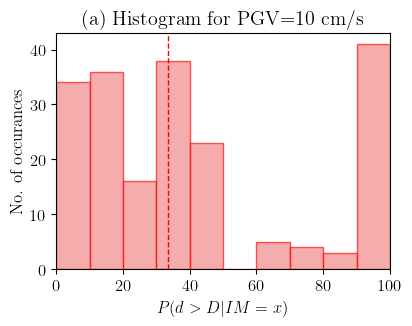

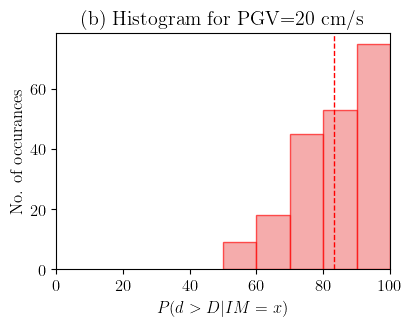

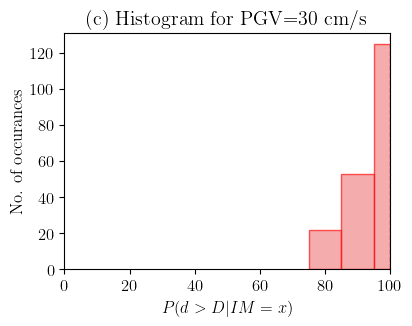

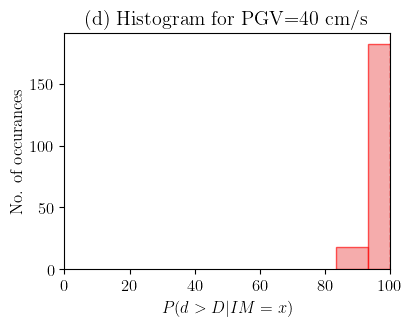

In [8]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib as pltuse
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

fmt = '%.0f%%'
pticks = mtick.FormatStrFormatter(fmt)

plt.rcParams.update({
    # Make the legend/label fonts a little smaller
    "text.usetex": True,
    "font.size": 12,
    "axes.labelsize": 12,
    "font.family": "Times New Roman",
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "figure.dpi" : 100,
    "figure.autolayout": True
    })


width = 412.56496

for y,sel_IM,title in zip([0,1,2,3,4],[10,20,30,40],['(a)','(b)','(c)','(d)']):
  fig, ax = plt.subplots(figsize=(width*0.75/72.27,width*0.6/72.27))
  ax.hist(NLTHA_BM_pivot[sel_IM]*100/12,color='lightcoral', edgecolor='red', alpha=0.65,bins=np.arange(min(NLTHA_BM_pivot[sel_IM]*100/12), max(NLTHA_BM_pivot[sel_IM]*100/12) + 10, 10))
  ax.set_xlim(0,100)
  ax.set_ylim(0)
  ax.set_title(title+' Histogram for PGV='+str(sel_IM)+' cm/s')
  ax.xaxis.set_major_formatter(pticks)
  ax.set_xlabel(r'$P(d>D|IM=x)$')
  ax.set_ylabel('No. of occurances')
  ax.axvline(np.median(NLTHA_BM_pivot[sel_IM]*100/12,axis=0),color='red', linestyle='--', linewidth=1)
  plt.savefig('histogram1020_benchmark_'+str(sel_IM)+'.pdf', backend='pdf', dpi=600, bbox_inches="tight", transparent=True)
  #tikzplotlib.save("histogram1020_benchmark_"+str(sel_IM)+".tex")

*   Median fragility model estimated from median probability of failure at each IM level.

IM
10    0.333333
dtype: float64

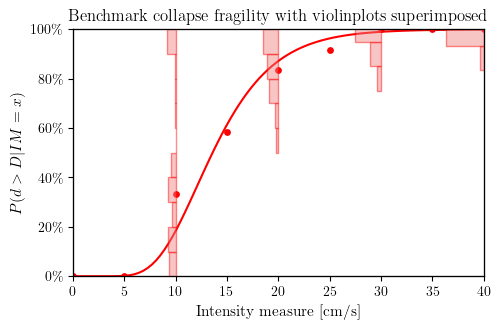

In [9]:
import matplotlib.ticker as ticker
#do not forget to make the straight line between 0 and 5 UPDATE: (DONE)

fmt = '%.0f%%'
pticks = mtick.FormatStrFormatter(fmt)

plt.rcParams.update({
    # Make the legend/label fonts a little smaller
    "text.usetex": True,
    "font.size": 11,
    "axes.labelsize": 11,
    "font.family": "Times New Roman",
    "legend.fontsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.titlesize": 12,
    "figure.figsize" : (20,10),
    "figure.dpi" : 100,
    "figure.autolayout": True
    })

fig, ax = plt.subplots(figsize=(width*0.9/72.27,width*0.6/72.27))
ax.set_xlim(0,40)
ax.set_ylim(0,100)
ax.yaxis.set_major_formatter(pticks)
ax.plot(np.linspace(0,40,100),NLTHA_BM_frag*100,linestyle='-',color='red')
ax.scatter(np.arange(0,45,5),np.median(NLTHA_BM_pivot,axis=0)*100/12,s=15,color='red')
ax.yaxis.set_major_formatter(ticker.PercentFormatter())
ax.set_xlabel('Intensity measure [cm/s]')
ax.set_ylabel(r'$P(d>D|IM=x) $')
ax.set_title('Benchmark collapse fragility with violinplots superimposed')
ax3 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax3.set_yticks([])
ax3 = ax.twiny()
ax3.set_xlim(0,40)
ax3.set_ylim(0,100)
ax3.set_xticks([])
ax3.invert_xaxis()

ax3.hist(NLTHA_BM_pivot[10]*100/12,color='lightcoral', edgecolor='red', alpha=0.45,bins=np.arange(min(NLTHA_BM_pivot[10]*100/12), max(NLTHA_BM_pivot[10]*100/12) + 10, 10), orientation='horizontal',weights=[0.02]*NLTHA_BM_pivot[10].count(),bottom=40-10)
ax3.hist(NLTHA_BM_pivot[20]*100/12,color='lightcoral', edgecolor='red', alpha=0.45,bins=np.arange(min(NLTHA_BM_pivot[20]*100/12), max(NLTHA_BM_pivot[20]*100/12) + 10, 10), orientation='horizontal',weights=[0.02]*NLTHA_BM_pivot[20].count(),bottom=30-10)
ax3.hist(NLTHA_BM_pivot[30]*100/12,color='lightcoral', edgecolor='red', alpha=0.45,bins=np.arange(min(NLTHA_BM_pivot[30]*100/12), max(NLTHA_BM_pivot[30]*100/12) + 10, 10), orientation='horizontal',weights=[0.02]*NLTHA_BM_pivot[30].count(),bottom=20-10)
ax3.hist(NLTHA_BM_pivot[40]*100/12,color='lightcoral', edgecolor='red', alpha=0.45,bins=np.arange(min(NLTHA_BM_pivot[40]*100/12), max(NLTHA_BM_pivot[40]*100/12) + 10, 10), orientation='horizontal',weights=[0.02]*NLTHA_BM_pivot[40].count(),bottom=10-10)
#ax3.violinplot(np.array(NLTHA_BM_pivot[[10,20]]*100/12),positions=[40-10,40-20],widths=5) # replaced with histograms
plt.savefig('finalfrag_bmark.pdf', backend='pdf', dpi=600, bbox_inches="tight", transparent=True)
NLTHA_BM_pivot[[10]].median()/12

*   Distribution of the limit states (before normalization) generated from Monte Carlo simulations.

In [10]:
NLTHA_BM_realvalues_pivot = pd.pivot_table(NLTHA_BM, values='state', index=['ecu','Vult'],columns=['IM'], aggfunc=np.sum)  #merging rows makes more problems so leave them as they are
NLTHA_BM_realvalues_pivot

,IM,5,10,15,20,25,30,35,40
ecu,Vult,,,,,,,,
-0.015041,184.074367,0,0,2,6,8,10,9,11
-0.013335,236.986156,0,0,3,6,9,10,10,11
-0.012734,159.310648,0,0,3,7,10,10,8,10
-0.012236,209.987804,0,0,3,7,10,10,10,11
-0.011964,181.436771,0,0,3,8,10,10,9,10
...,...,...,...,...,...,...,...,...,...
-0.002815,161.504097,0,5,10,11,12,12,12,12
-0.002785,163.178213,0,5,10,12,12,12,12,12
-0.002288,197.026214,2,9,12,12,12,12,12,12


* Distribution of the limit states (before normalization) generated from Monte Carlo simulations.


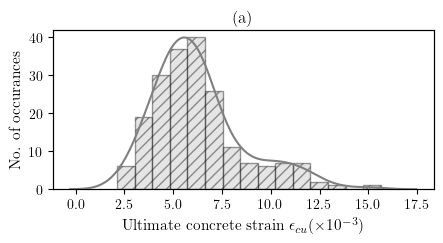

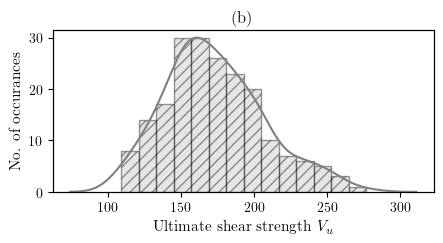

In [11]:
import seaborn as sns

ecu_BM, Vult_BM = zip(*NLTHA_BM_realvalues_pivot.index.values)
ecu_BM, Vult_BM = np.array(ecu_BM),np.array(Vult_BM)
fig, ax = plt.subplots(figsize=(width*0.8/72.27,width*0.45/72.27))
ax.set_title('(a)')
ax.hist(-ecu_BM*1000,color='silver', edgecolor='k', alpha=0.4, bins=np.arange(min(-ecu_BM*1000), max(-ecu_BM*1000) + 0.9, 0.9),hatch='///')
ax.set_xlabel(r'Ultimate concrete strain $\epsilon _{cu}  (\times 10^{-3})$')
ax.set_ylabel('No. of occurances')

ax2 = ax.twinx()
sns.kdeplot(-ecu_BM*1000, ax=ax2,color='gray')
ax2.set_yticks([])
ax2.set_ylabel('')

plt.savefig('histogram_criteria_e.pdf', backend='pdf', dpi=200, bbox_inches="tight", transparent=True)

fig, ax = plt.subplots(figsize=(width*0.8/72.27,width*0.45/72.27))
ax.set_title('(b)')
ax.hist(Vult_BM,color='silver', edgecolor='k', alpha=0.4, bins=np.arange(min(Vult_BM), max(Vult_BM) + 12, 12),hatch='///')
ax.set_xlabel(r'Ultimate shear strength $V_{u}$')
ax.set_ylabel('No. of occurances')
ax2 = ax.twinx()
sns.kdeplot(Vult_BM, ax=ax2,color='gray')
ax2.set_yticks([])
ax2.set_ylabel('')

plt.savefig('histogram_criteria_V.pdf', backend='pdf', dpi=200, bbox_inches="tight", transparent=True)

*   Log-mean estimations for each limit state combination in the dataset.

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df

array([ 6.85,  7.31,  7.31, 10.85, 11.06, 11.7 , 11.7 , 11.82, 11.96,
       11.7 , 11.7 , 11.7 , 11.7 , 11.7 ,  5.  , 11.89, 11.89, 11.89,
        5.21, 11.89, 11.89,  5.21,  5.49,  5.21, 12.23,  5.49,  5.21,
       12.51, 13.02,  5.  , 12.51, 12.03,  5.  ,  5.  ,  7.13, 13.07,
       13.02, 13.07, 13.07, 13.07, 13.02,  5.21,  5.  ,  5.  ,  5.21,
       13.02, 13.02, 13.02,  5.  , 13.02, 13.02, 13.02, 12.52,  5.  ,
       13.02, 13.02, 13.02, 13.02, 13.02, 13.02, 13.02, 13.02, 13.02,
       13.02,  5.  , 13.25, 13.25,  5.21,  6.56, 13.25, 13.49, 13.49,
       13.49, 13.49, 10.85, 13.25, 13.25,  5.21, 13.55, 13.8 , 14.1 ,
       14.1 ,  5.  , 14.1 , 13.8 , 13.8 , 13.8 , 13.8 , 13.8 ,  5.21,
       13.8 , 13.8 , 13.8 , 13.8 , 13.99,  5.  , 13.99,  6.99,  5.  ,
       14.58, 14.58,  5.  ,  5.88,  5.49, 14.58, 14.9 , 14.9 , 14.9 ,
       15.73, 13.55,  7.63, 14.9 , 14.9 ,  5.  , 14.9 , 14.3 , 14.9 ,
       14.9 ,  5.21, 14.9 , 14.9 , 12.74,  5.21, 15.31, 15.31,  7.63,
       15.31, 15.59,

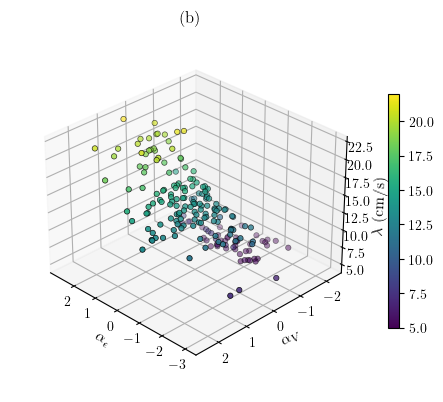

In [12]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

NLTHA_BM_pivot = pd.pivot_table(NLTHA_BM, values='state', index=['ecu_alpha','Vult_alpha'],columns=['IM'], aggfunc=np.sum)  #merging rows makes more problems so leave them as they are
NLTHA_BM_pivot.insert(0,0,0)
NLTHA_BM_pivot= NLTHA_BM_pivot/12

ecu_BM_alpha_frag, Vult_BM_alpha_frag = zip(*NLTHA_BM_pivot.index.values)
ecu_BM_alpha_frag, Vult_BM_alpha_frag = np.asarray(ecu_BM_alpha_frag), np.asarray(Vult_BM_alpha_frag)

result_BM_list = pd.DataFrame(columns = ['ecu_BM','Vult_BM','theta_BM','beta_BM'])
theta_BM_list = []
beta_BM_list = []

IM = np.arange(0,45,5)
fragility_function = []
fragility_table = pd.DataFrame(columns = ['0','5','10','15','20','25','30','35','40'])
z_list = []

np.seterr(divide = 'ignore')

def frag(thetabeta):
    estimated_fragility = sps.norm.cdf(np.log(factor_list),np.log(thetabeta[0]),thetabeta[1])
    log_likelihood = np.log(sps.binom.pmf(pcllps*nrcrds,nrcrds,estimated_fragility))
    fun = -np.sum(log_likelihood)

    return fun

for i,ecu_i in enumerate(ecu_BM_alpha_frag):
    factor_list = np.array([0,5,10,15,20,25,30,35,40])
    pcllps = NLTHA_BM_pivot.iloc[i]
    nrcrds = 12
    ncllps = pcllps*nrcrds

    # starting guess
    theta, beta = 25,0.5

    # Bounds
    bnds = ((5, 50), (0.2, 1))

    thetabeta_start = [theta,beta]

    result = spo.minimize(frag,thetabeta_start,options={'disp': True},bounds=bnds)

    if result.success:
        #print("Success!", end = '\n')
        miny = result.x
        theta_mxlk = round(miny[0],2)
        beta_mxlk = round(miny[1],2)
        theta_BM_list.append(theta_mxlk)
        beta_BM_list.append(beta_mxlk)

        z_mxlk = -round(result.fun,2)
        z_list.append(z_mxlk)
        fragility_table.loc[i] = sps.norm.cdf(np.log(IM),np.log(theta_mxlk),beta_mxlk)

theta_BM_list = np.array(theta_BM_list)
beta_BM_list = np.array(beta_BM_list)

result_BM_list['ecu_BM']=ecu_BM_alpha_frag
result_BM_list['Vult_BM']=Vult_BM_alpha_frag
result_BM_list['theta_BM']=theta_BM_list
result_BM_list['beta_BM']=beta_BM_list


# Creating plot
fig, ax = plt.subplots(figsize=(width*0.8/72.27,width*0.8/72.27),subplot_kw={'projection': '3d'})
ax.autoscale(enable=True, axis='x', tight=True)
ax.set_zlabel(r"$\lambda$ (cm/s)",labelpad=-5)
ax.set_xlabel(r"$\alpha_\epsilon$",labelpad=-5)
ax.set_ylabel(r"$\alpha_{V}$",labelpad=-5)
ax.set_title("(b)")
ax.tick_params(axis='both', which='major', pad=-2)
ax.azim = 135
ax.set_box_aspect(aspect=None, zoom=0.9)

bmark_scatter = ax.scatter(ecu_BM_alpha_frag, Vult_BM_alpha_frag, theta_BM_list,c=theta_BM_list,s=15,edgecolors='black', cmap='viridis',linewidth=0.5)
fig.colorbar(bmark_scatter, ax=ax,fraction=0.03, pad=0.04)
plt.savefig('bmark_lambda.pdf', backend='pdf', dpi=200, bbox_inches='tight')


fig.show()
theta_BM_list



# 2.2 **Response Surface Method:**

Central composite design is used as a sampling method for the training data set. A response surface is then developed by fitting a polynomial surface.

### 2.2.1 Preparing the training dataset

Nonlinear time history analysis results are retrieved from the project repository, and the limit states are normalized to meta-variables.

In [13]:
NLTHA_RSM = pd.read_csv('https://github.com/mtareqsoliman/msthesis/blob/main/CaseStudy_1/sims_RSM_c1.csv?raw=true')

ecu_RSM_alpha = sps.lognorm.cdf(-np.array(NLTHA_RSM[['ecu']]), scale=0.006,s=np.sqrt(np.log(1+(0.35)**2)))
Vult_RSM_alpha = sps.lognorm.cdf(np.array(NLTHA_RSM[['Vult']]), scale=170,s=np.sqrt(np.log(1+(0.20)**2)))

ecu_RSM_alpha, Vult_RSM_alpha = sps.norm.ppf(ecu_RSM_alpha,0,1) , sps.norm.ppf(Vult_RSM_alpha,0,1)

print(ecu_RSM_alpha.mean())
print(ecu_RSM_alpha.std())


NLTHA_RSM.insert(11,'ecu_alpha_2',ecu_RSM_alpha) # for recheck
NLTHA_RSM.insert(13,'Vult_alpha_2',Vult_RSM_alpha) # for recheck

del ecu_RSM_alpha, Vult_RSM_alpha

NLTHA_RSM.head(10)

-0.021107741888713494
0.8923665326021825


,state,IM,record,ecu,Vult,Vbmax,ect,ecb,uindex,convergence,ecu_alpha,ecu_alpha_2,Vult_alpha,Vult_alpha_2
0,1,40,RSN126_GAZLI_GAZ000,-0.003667,174.4819,150.040474,-0.003102,-0.142218,0,0,-1.414,-1.448454,0.000,0.131399
1,1,40,RSN126_GAZLI_GAZ000,-0.004356,137.1152,150.040474,-0.002764,-0.142377,573,0,-1.000,-0.941950,-1.000,-1.085511
2,1,40,RSN126_GAZLI_GAZ000,-0.004356,205.5083,150.040474,-0.002764,-0.142377,947,0,-1.000,-0.941950,1.000,0.957816
3,1,40,RSN126_GAZLI_GAZ000,-0.006019,121.6374,150.040474,-0.003032,-0.143854,566,0,0.000,0.009301,-1.414,-1.690316
4,1,40,RSN126_GAZLI_GAZ000,-0.006019,174.4819,150.040474,-0.003032,-0.143854,950,0,0.000,0.009301,0.000,0.131399
5,1,40,RSN126_GAZLI_GAZ000,-0.006019,218.3598,150.040474,-0.003032,-0.143854,950,0,0.000,0.009301,1.414,1.264103
6,1,40,RSN126_GAZLI_GAZ000,-0.008243,137.1152,151.382821,-0.111416,-0.156831,573,0,1.000,0.934300,-1.000,-1.085511
7,1,40,RSN126_GAZLI_GAZ000,-0.008243,205.5083,151.382821,-0.111416,-0.156831,953,0,1.000,0.934300,1.000,0.957816
8,1,40,RSN126_GAZLI_GAZ000,-0.009164,174.4819,153.179390,-0.002285,-0.104259,1061,FAILED,1.414,1.245881,0.000,0.131399
9,1,35,RSN126_GAZLI_GAZ000,-0.003667,174.4819,146.688920,-0.001924,-0.110376,0,FAILED,-1.414,-1.448454,0.000,0.131399


The table displays the number of failures at each IM level for each limit state combination (out of 12 simulations per each IM level).

In [14]:
NLTHA_RSM_pivot = pd.pivot_table(NLTHA_RSM, values='state', index=['ecu_alpha','Vult_alpha'],columns=['IM'], aggfunc=np.sum)  #merging rows makes more problems so leave them as they are
NLTHA_RSM_pivot.insert(0,0,0)

NLTHA_RSM_pivot

IM                    0   5   10  15  20  25  30  35  40
ecu_alpha Vult_alpha                                    
-1.414     0.000       0  12  12  12  12  12  12  12  12
-1.000    -1.000       0   5  12  12  12  12  12  12  12
           1.000       0   0   5   7  10  11  12  12  12
 0.000    -1.414       0   9  12  12  12  12  12  12  12
           0.000       0   0   2   7   9  10  11  12  12
           1.414       0   0   2   7   9  10  11  12  12
 1.000    -1.000       0   5  12  12  12  12  12  12  12
           1.000       0   0   1   3   7  10  11  12  12
 1.414     0.000       0   0   1   4   8  10  11  12  12

### 2.2.2 Calculating fragility model parameters for each limit state combination.

For each meta-variable combination, the probability of failures is curve-fitted with a log-normal CDF function. The parameters λ and ζ, defining the CDF function, are estimated using the least squares method. Fragility model for each of the central composite design points is developed from these estimations.

λ=21.96, ζ=0.42, cost=-9.02
λ=5.0, ζ=0.2, cost=-8.32
λ=5.21, ζ=0.2, cost=-1.48
λ=12.51, ζ=0.44, cost=-6.37
λ=5.0, ζ=0.2, cost=-2.93
λ=14.9, ζ=0.43, cost=-7.1
λ=14.9, ζ=0.43, cost=-7.1
λ=5.21, ζ=0.2, cost=-1.48
λ=23.01, ζ=0.35, cost=-14.37
IM                    0   5   10  15  20  25  30  35  40
ecu_alpha Vult_alpha                                    
-1.0      -1.0         0   5  12  12  12  12  12  12  12
IM                    0   5   10  15  20  25  30  35  40
ecu_alpha Vult_alpha                                    
0.0       0.0          0   0   2   7   9  10  11  12  12
IM                    0   5   10  15  20  25  30  35  40
ecu_alpha Vult_alpha                                    
-1.0      1.0          0   0   5   7  10  11  12  12  12
IM                    0   5   10  15  20  25  30  35  40
ecu_alpha Vult_alpha                                    
1.0       -1.0         0   5  12  12  12  12  12  12  12
IM                    0   5   10  15  20  25  30  35  40
ecu_alpha Vult_alpha

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


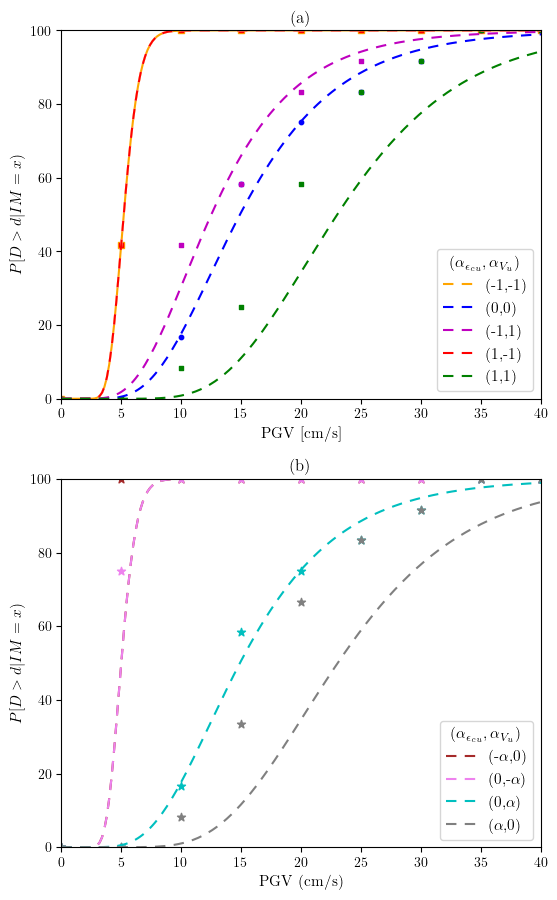

In [15]:
ecu_RSM_alpha_frag, Vult_RSM_alpha_frag = zip(*NLTHA_RSM_pivot.index.values)

lambda_RSM_list, zeta_RSM_list, z_RSM_list = [], [], []
IM = np.arange(0,45,5)
fragility_table_RSM = pd.DataFrame(columns = ['0','5','10','15','20','25','30','35','40'])

def frag(lambdazeta):
    estimated_fragility = sps.norm.cdf(np.log(factor_list),np.log(lambdazeta[0]),lambdazeta[1])
    log_likelihood = np.log(sps.binom.pmf(ncllps_RSM_i,nrcrds,estimated_fragility))
    fun = -np.sum(log_likelihood)

    return fun

for i,ecu_i in enumerate(ecu_RSM_alpha_frag[0:9]):
    factor_list = np.array([0,5,10,15,20,25,30,35,40])
    ncllps_RSM_i = NLTHA_RSM_pivot.iloc[i]
    nrcrds = 12

    # starting guess
    lambdazeta_start = [25,0.6]

    # Bounds
    bnds = ((5, 50), (0.2, 1))

    result = spo.minimize(frag,lambdazeta_start,options={'disp': True},bounds=bnds)

    if result.success:
        print('\u03BB='+str(lambda_mxlk)+', \u03B6='+str(zeta_mxlk)+', cost='+str(z_mxlk), end = '\n')
        miny = result.x
        lambda_mxlk = round(miny[0],2)
        zeta_mxlk = round(miny[1],2)
        lambda_RSM_list.append(lambda_mxlk)
        zeta_RSM_list.append(zeta_mxlk)

        z_mxlk = -round(result.fun,2)
        z_RSM_list.append(z_mxlk)

    else:
        print("Failed!", end = '\n')
        miny = result.x
        lambda_mxlk = round(miny[0],2)
        zeta_mxlk = round(miny[1],2)
        lambda_RSM_list.append(lambda_mxlk)
        zeta_RSM_list.append(zeta_mxlk)

        z_mxlk = -round(result.fun,2)
        z_RSM_list.append(z_mxlk)
        fragility_table_RSM.loc[i] = np.ceil(sps.norm.cdf(np.log(IM),np.log(lambda_mxlk),zeta_mxlk)*12)


ecu_names = [r'(-$\alpha$,0)','(-1,-1)','(-1,1)',r'(0,-$\alpha$)','(0,0)',r'(0,$\alpha$)','(1,-1)','(1,1)',r'($\alpha$,0)']

IM_list = [0,5,10,15,20,25,30,35,40]
IM_arange = np.arange(0,50.2,0.2)

cycler1 = (cycler(color=['b','m','r','g']))


star_points = [0,3,5,8]   # manually selected, needs to be automatically detected
axial_points = [2,6,7]
axial_int = [1]
center_point = [4]

fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(width*1/72.27,width*1.6/72.27))
for i in axial_int:
    fragility_function = sps.norm.cdf(np.log(IM_arange),np.log(lambda_RSM_list[i]),zeta_RSM_list[i])
    ax[0].plot(IM_arange,fragility_function*100,label=ecu_names[i],ls='--',color='orange', dashes=[5, 4])
    ax[0].plot(IM_arange,fragility_function*100,ls='--',color='white', gapcolor='orange',dashes=[5, 4])
    ax[0].scatter(IM_list,NLTHA_RSM_pivot.iloc[[i]]*100/12,marker='s',s=20,color='orange',edgecolors='orange')
    print(NLTHA_RSM_pivot.iloc[[i]])

ax[0].set_prop_cycle(cycler1)
leg =  ax[0].legend(title=r'$(\alpha_{\epsilon_{cu}},\alpha_{V_{u}})$')
ax[0].set_xlabel('PGV (cm/s)')
ax[0].set_ylabel(r'$P[D>d|IM=x)$')
ax[0].set_title('(a)')
ax[0].set_xlim(0,40)
ax[0].set_ylim(0,100)


for i in center_point:
    fragility_function = sps.norm.cdf(np.log(IM_arange),np.log(lambda_RSM_list[i]),zeta_RSM_list[i])
    ax[0].plot(IM_arange,fragility_function*100,label=ecu_names[i],ls='--', dashes=[5, 4])
    ax[0].scatter(IM_list,NLTHA_RSM_pivot.iloc[[i]]*100/12,marker='o',s=10)
    print(NLTHA_RSM_pivot.iloc[[i]])

ax[0].set_xlabel('PGV (cm/s)')
ax[0].set_ylabel(r'$P[D>d|IM=x)$')
ax[0].set_title('(a)')
ax[0].set_xlim(0,40)
ax[0].set_ylim(0,100)

for i in axial_points:
    fragility_function = sps.norm.cdf(np.log(IM_arange),np.log(lambda_RSM_list[i]),zeta_RSM_list[i])
    ax[0].plot(IM_arange,fragility_function*100,label=ecu_names[i],ls='--', dashes=[5, 4])

    ax[0].scatter(IM_list,NLTHA_RSM_pivot.iloc[[i]]*100/12,marker='s',s=5)
    print(NLTHA_RSM_pivot.iloc[[i]])
ax[0].legend(title=r'$(\alpha_{\epsilon_{cu}},\alpha_{V_{u}})$')
ax[0].set_xlabel('PGV [cm/s]')
ax[0].set_ylabel(r'$P[D>d|IM=x)$')
ax[0].set_title('(a)')
ax[0].set_xlim(0,40)
ax[0].set_ylim(0,100)

cycler2 = (cycler(color=['brown','violet','c','gray']))
ax[1].set_prop_cycle(cycler2)

for i in star_points:
    fragility_function = sps.norm.cdf(np.log(IM_arange),np.log(lambda_RSM_list[i]),zeta_RSM_list[i])
    ax[1].plot(IM_arange,fragility_function*100,label=ecu_names[i],ls='--', dashes=[5, 4])

    ax[1].scatter(IM_list,NLTHA_RSM_pivot.iloc[[i]]*100/12,marker='*')
ax[1].legend(title=r'$(\alpha_{\epsilon_{cu}},\alpha_{V_{u}})$')

ax[1].set_xlabel('PGV (cm/s)')
ax[1].set_ylabel(r'$P[D>d|IM=x)$')
ax[1].set_title('(b)')
ax[1].set_xlim(0,40)
ax[1].set_ylim(0,100)

plt.savefig('resFrag_vs_RSM.pdf', backend='pdf', dpi=600)

### 2.2.3 Fitting the polynomial response surface

From the estimated parameters of the 9 points, a 2nd-degree polynomial equation is approached using least square LinearRegression tool and fits a complete surface.

[[ 0.          0.34634164  0.48823336 -0.16982292  0.15235014 -0.27893201]
 [ 0.          0.01703257  0.089416   -0.07501263 -0.0225     -0.05750735]]


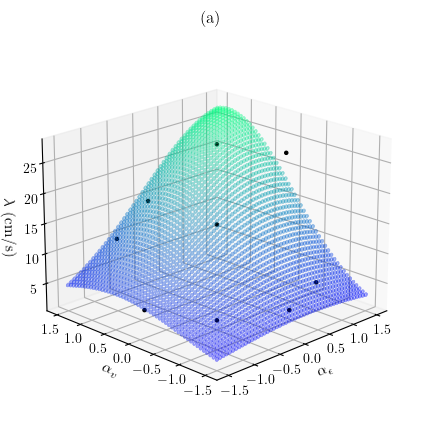

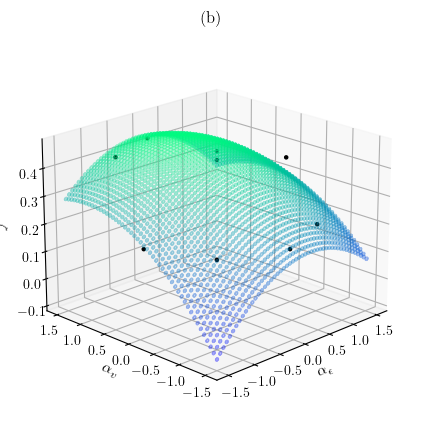

In [16]:

x1_RSM,x2_RSM = map(list,zip(*NLTHA_RSM_pivot.index.values))

x_RSM =np.column_stack((x1_RSM,x2_RSM))
y_RSM = np.column_stack((np.log(lambda_RSM_list),zeta_RSM_list))

################ 2nd degree
deg2_polymodel = PolynomialFeatures(degree=2)
x_poly_RSM_deg2 = deg2_polymodel.fit_transform(x_RSM)

# should be in the form [1, a, b, a^2, ab, b^2]
deg2_polymodel.fit(x_poly_RSM_deg2, y_RSM)
deg2_RSM_regmodel = LinearRegression()
deg2_RSM_regmodel.fit(x_poly_RSM_deg2, y_RSM)

y_pred_deg2 = deg2_RSM_regmodel.predict(x_poly_RSM_deg2)
print(deg2_RSM_regmodel.coef_)
#p00,p10,p01,p20,p11,p02 = deg2_RSM_regmodel.coef_.T
MSE = mean_squared_error(y_RSM, y_pred_deg2, squared=False)

x1_mesh,x2_mesh = np.linspace(-1.5, 1.5, 50), np.linspace(-1.5, 1.5, 50)
x1_mesh, x2_mesh = np.meshgrid(x1_mesh, x2_mesh)
x_mesh = np.array([x1_mesh.flatten(), x2_mesh.flatten()]).T
poly_x_mesh = deg2_polymodel.fit_transform(x_mesh)
y_mesh_deg2 = deg2_RSM_regmodel.predict(poly_x_mesh)


plt.rcParams['figure.figsize'] = (width*0.8/72.27,width*0.4/72.27)
plt.rcParams['figure.dpi'] = 100

#fig, ax = plt.subplots(figsize =(18,10), subplot_kw={'projection': '3d'})
fig, ax = plt.subplots(figsize=(width*1.4/72.27,width*0.8/72.27),subplot_kw={'projection': '3d'})
ax.autoscale(enable=True, axis='x', tight=True)
ax.set_zlabel(r"$\lambda$ (cm/s)",labelpad=-5)
ax.set_xlabel(r"$\alpha_\epsilon$",labelpad=-5)
ax.set_ylabel(r"$\alpha_v$",labelpad=-5)
ax.set_title("(a)")
ax.tick_params(axis='both', which='major', pad=-2.5,)
ax.view_init(20,180+45)
ax.set_box_aspect(aspect=None, zoom=0.94)


#fig.tight_layout(pad=-5.0)


ax.scatter(x_RSM[:,0], x_RSM[:,1], np.exp(y_RSM[:,0]),color='black',marker='.',alpha=1,s=20)
sc_2 = ax.scatter(x1_mesh, x2_mesh, np.exp(y_mesh_deg2[:,0]), c=np.exp(y_mesh_deg2[:,0]),marker="$\u25EF$", s=5, cmap='winter',alpha=0.35)
plt.savefig('RSM_surf_2nd_lambda.pdf', backend='pdf', dpi=200, bbox_inches='tight')


fig, ax = plt.subplots(figsize=(width*1.4/72.27,width*0.8/72.27),subplot_kw={'projection': '3d'})
#ax.autoscale(enable=True, axis='x', tight=True)
ax.set_zlabel(r"$\zeta$",labelpad=-2)
ax.set_xlabel(r"$\alpha_\epsilon$",labelpad=-5)
ax.set_ylabel(r"$\alpha_v$",labelpad=-5)
ax.set_title("(b)")
ax.tick_params(axis='both', which='major', pad=-1.5)
ax.view_init(20,180+45)
ax.set_box_aspect(aspect=None, zoom=0.94)

#fig.tight_layout(pad=-5.0)


ax.scatter(x_RSM[:,0], x_RSM[:,1], y_RSM[:,1],color='black',marker='.',alpha=1,s=20)
sc_2 = ax.scatter(x1_mesh, x2_mesh, y_mesh_deg2[:,1], c=y_mesh_deg2[:,1],marker="$\u25EF$", s=5, cmap='winter',alpha=0.35)

#fig.tight_layout(pad=1.0)
plt.savefig('RSM_surf_2nd_zeta.pdf', backend='pdf', dpi=200, bbox_inches='tight')

# should be in the form [1, a, b, a^2, ab, b^2]

A 3rd-degree polynomial equation is also tested, results however fails to fulfill expectations and and as a result the 3rd-degree polynomial is overlooked in the study.

[[ 5.55111512e-17  5.08224712e-02  1.96754235e-01 -1.69822922e-01
   1.52350145e-01 -2.78932012e-01  2.44858585e-01  2.98862914e-01
  -1.43330911e-01  9.47072302e-02]
 [ 0.00000000e+00 -7.49203522e-03  3.24983732e-02 -7.50126350e-02
  -2.25000000e-02 -5.75073484e-02  3.20442381e-02  4.05786569e-02
  -4.70522029e-02  2.44229699e-02]]


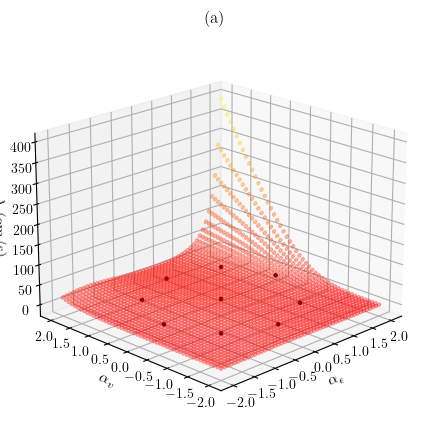

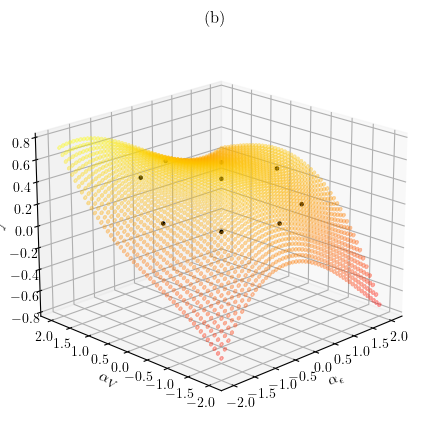

In [17]:
x1_RSM,x2_RSM = map(list,zip(*NLTHA_RSM_pivot.index.values))

x_RSM =np.column_stack((x1_RSM,x2_RSM))
y_RSM = np.column_stack((np.log(lambda_RSM_list),zeta_RSM_list))

################ 3rd degree
deg3_polymodel = PolynomialFeatures(degree=3)
x_poly_RSM_deg3 = deg3_polymodel.fit_transform(x_RSM)

deg3_polymodel.fit(x_poly_RSM_deg3, y_RSM)
deg3_RSM_regmodel = LinearRegression()
deg3_RSM_regmodel.fit(x_poly_RSM_deg3, y_RSM)

y_pred_deg3 = deg3_RSM_regmodel.predict(x_poly_RSM_deg3)
print(deg3_RSM_regmodel.coef_)
MSE = mean_squared_error(y_RSM, y_pred_deg3, squared=False)

x1_mesh,x2_mesh = np.linspace(-2, 2, 50), np.linspace(-2, 2, 50)
x1_mesh, x2_mesh = np.meshgrid(x1_mesh, x2_mesh)
x_mesh = np.array([x1_mesh.flatten(), x2_mesh.flatten()]).T
poly_x_mesh = deg3_polymodel.fit_transform(x_mesh)
y_mesh_deg2 = deg3_RSM_regmodel.predict(poly_x_mesh)


plt.rcParams['figure.figsize'] = (width*0.8/72.27,width*0.4/72.27)
plt.rcParams['figure.dpi'] = 100

#fig, ax = plt.subplots(figsize =(18,10), subplot_kw={'projection': '3d'})
fig, ax = plt.subplots(figsize=(width*0.8/72.27,width*0.8/72.27),subplot_kw={'projection': '3d'})
ax.autoscale(enable=True, axis='x', tight=True)
ax.set_zlabel(r"$\lambda$ (cm/s)",labelpad=-5)
ax.set_xlabel(r"$\alpha_\epsilon$",labelpad=-5)
ax.set_ylabel(r"$\alpha_v$",labelpad=-5)
ax.set_title("(a)")
ax.tick_params(axis='both', which='major', pad=-2)
ax.view_init(20,180+45)

ax.scatter(x_RSM[:,0], x_RSM[:,1], np.exp(y_RSM[:,0]),color='black',marker='.',alpha=1,s=20)
sc_2 = ax.scatter(x1_mesh, x2_mesh, np.exp(y_mesh_deg2[:,0]), c=np.exp(y_mesh_deg2[:,0]),marker="$\u25EF$", s=5, cmap='autumn',alpha=0.35)

plt.savefig('RSM_surf_3rd_lambda.pdf', backend='pdf', dpi=600)

fig, ax = plt.subplots(figsize=(width*0.8/72.27,width*0.8/72.27),subplot_kw={'projection': '3d'})
ax.autoscale(enable=True, axis='x', tight=True)
ax.set_zlabel(r"$\zeta$",labelpad=-5)
ax.set_xlabel(r"$\alpha_\epsilon$",labelpad=-5)
ax.set_ylabel(r"$\alpha_{V}$",labelpad=-5)
ax.set_title("(b)")
ax.tick_params(axis='both', which='major', pad=-2)
ax.view_init(20,180+45)

ax.scatter(x_RSM[:,0], x_RSM[:,1], y_RSM[:,1],color='black',marker='.',alpha=1,s=20)
sc_2 = ax.scatter(x1_mesh, x2_mesh, y_mesh_deg2[:,1], c=y_mesh_deg2[:,1],marker="$\u25EF$", s=5, cmap='autumn',alpha=0.35)
plt.savefig('RSM_surf_3rd_zeta.pdf', backend='pdf', dpi=600)

### 2.2.4 Developing median RSM model from ample random samples

a huge set of random limit states combinations is generated. This will be useed in developing the median fragility model of the RSM.

In [18]:
alpha_ecu_1000 = np.random.normal(0, 1, 1000)
alpha_Vult_1000 = np.random.normal(0, 1, 1000)

x_1000_RSM = np.array([alpha_ecu_1000, alpha_Vult_1000]).T
x_1000_poly_RSM_deg2 = deg2_polymodel.fit_transform(x_1000_RSM)
y_1000_RSM_deg2 = deg2_RSM_regmodel.predict(x_1000_poly_RSM_deg2)


fragility_table_RSM_1000_deg2 = pd.DataFrame(columns = ['0','5','10','15','20','25','30','35','40'])

for i in np.arange(len(y_1000_RSM_deg2)):
  fragility_table_RSM_1000_deg2.loc[i] = sps.norm.cdf(np.log(IM),y_1000_RSM_deg2[i,0],y_1000_RSM_deg2[i,1])*12

def frag(lambdazeta):
    estimated_fragility = sps.norm.cdf(np.log(factor_list),np.log(lambdazeta[0]),lambdazeta[1])
    log_likelihood = np.log(sps.binom.pmf(ncllps_CCM1000_deg2,12,estimated_fragility))
    fun = -np.sum(log_likelihood)

    return fun

factor_list = np.array([0,5,10,15,20,25,30,35,40])
nrcrds = 12
ncllps_CCM1000_deg2 = np.round(fragility_table_RSM_1000_deg2.median())
pcllps_CCM1000_deg2 = ncllps_CCM1000_deg2/12

lambdazeta_start = np.array([15,0.4]) # starting guess
bnds = ((4, 50), (0.2, 1)) # Bounds

result = spo.minimize(frag,lambdazeta_start,options={'disp': True},bounds=bnds)
RSM_1000_lgnrml = []
if result.success:
    print("Success!", end = '\n')
    miny = result.x
    RSM_1000_lambda = round(miny[0],2)
    RSM_1000_zeta = round(miny[1],2)
    RSM_1000_cost = -round(result.fun,2)

RSM_1000_lz_deg2 = [RSM_1000_lambda,RSM_1000_zeta,RSM_1000_cost]
RSM_1000_lgnrml_deg2 = sps.norm.cdf(np.log(np.linspace(0,40,1000)),np.log(RSM_1000_lz_deg2[0]),RSM_1000_lz_deg2[1])

RSM_1000_lz_deg2

Success!


[11.86, 0.33, -4.08]

### 2.2.4 Plotting

*   Residual errors for the RSM-based model from predictions of fragility model parameters at each limit state combination of the benchmark.

0.7705518160944297


0.6507725368726786




'\ntest_y_residual = (test_y_pred-test_y)\n\n\nfig = plt.figure(figsize =(14, 9))\nax = plt.axes(projection =\'3d\')\n\n\nax.set_xlabel(r"$\x07lpha_\\epsilon$",fontsize=16)\nax.set_ylabel(r"$\x07lpha_v$",fontsize=16)\nax.set_zlabel(r"$\theta$ residual (cm/sec)",fontsize=14)\nax.set_zlim(-1,1)\n\nax.scatter(x_BM[:,0], x_BM[:,1], (y_pred-y_BM[:,0])/y_BM[:,0],color=\'black\',marker=\'.\',alpha=1,s=70)\nax.scatter(test_x[:,0], test_x[:,1], test_y_residual/test_y,color=\'black\',marker=\'.\',alpha=0.25,s=70)\n'

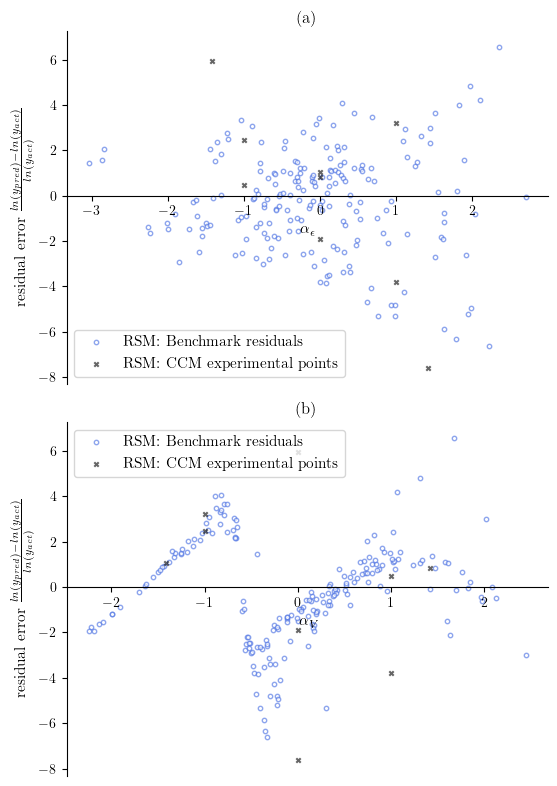

In [19]:
######## testing phase ################
'''
## cleaning data

# Detection
# IQR
Q1 = np.percentile(result_100_list[['theta_100']], 16,
                   interpolation = 'midpoint')

Q3 = np.percentile(result_100_list[['theta_100']], 84,
                   interpolation = 'midpoint')
IQR = Q3 - Q1

# Upper bound
upper = np.where(result_100_list[['theta_100']] >= (Q3+1.5*IQR))[0]
# Lower bound
lower = np.where(result_100_list[['theta_100']] <= (Q1-1.5*IQR))[0]

# Removing the Outliers
result_100_cleaned = pd.DataFrame(result_100_list)

result_100_cleaned[['theta_100']].drop(upper[0], inplace = True)
result_100_cleaned[['theta_100']].drop(lower[0], inplace = True)
'''

x1_BM,x2_BM = map(list,zip(*NLTHA_BM_pivot.index.values))
x_BM =np.column_stack((x1_BM,x2_BM))
y_BM = np.column_stack((np.log(lambda_BM_list),zeta_BM_list))

fig,ax = plt.subplots(2,1,figsize=(width*1/72.27,width*0.7*2/72.27))
for i,clr,eclr,test_x,test_y,mrkr,alpha in zip(['RSM: Benchmark residuals','RSM: CCM experimental points'],['white','black'],['royalblue',None],[x_BM,x_RSM],[np.log(lambda_BM_list),np.log(lambda_RSM_list)],['o','x'],[0.45,0.5]):
    poly_model = PolynomialFeatures(degree=2)
    poly_x_values = poly_model.fit_transform(x_BM)
    # should be in the form [1, a, b, a^2, ab, b^2]
    regression_model = LinearRegression()
    regression_model.fit(poly_x_values, y_BM[:,0])
    y_pred = regression_model.predict(poly_x_values)
    #p00,p10,p01,p20,p11,p02 = regression_model.coef_.T
    MSE = mean_squared_error(y_BM[:,0], y_pred, squared=False)
    test_poly_x =  poly_model.fit_transform(test_x)

    test_y_pred = regression_model.predict(test_poly_x)
    r2 = r2_score(test_y, test_y_pred)
    test_y_residual = np.exp(test_y_pred)-np.exp(test_y)

    print(r2)
    ax[0].scatter(test_x[:,0],test_y_residual,color=clr,s=10,label=i,alpha=0.6,edgecolors=eclr,marker=mrkr)
    ax[0].spines['bottom'].set_position('zero')
    ax[0].spines['right'].set_color('none')
    ax[0].spines['top'].set_color('none')
    #ax[0].set_title(r"Relative error for $\lambda$ with respect to $\alpha_\epsilon$")
    ax[0].set_title("(a)")
    ax[0].set_ylabel(r"residual error $\frac{ln(y_{pred})-ln(y_{act})}{ln(y_{act})}$")
    ax[0].set_xlabel(r"$\alpha_{\epsilon}$")
    ax[0].legend()

    #ax[1].scatter(test_x[:,1],test_y_residual,color=clr,s=10,label=i,alpha=0.5,edgecolors=eclr)
    ax[1].scatter(test_x[:,1],test_y_residual,color=clr,s=10,label=i,alpha=0.6,edgecolors=eclr,marker=mrkr)
    ax[1].spines['bottom'].set_position('zero')
    ax[1].spines['right'].set_color('none')
    ax[1].spines['top'].set_color('none')
    #ax[1].set_title(r"Relative error for $\lambda$ with respect to $\alpha_V$")
    ax[1].set_title("(b)")
    ax[1].set_xlabel(r"$\alpha_V$")
    ax[1].set_ylabel(r"residual error $\frac{ln(y_{pred})-ln(y_{act})}{ln(y_{act})}$")
    ax[1].legend()
    print('\n')

plt.savefig('reserror_graph.pdf', backend='pdf', dpi=600)


## graphing residual plot
'''
test_y_residual = (test_y_pred-test_y)


fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')


ax.set_xlabel(r"$\alpha_\epsilon$",fontsize=16)
ax.set_ylabel(r"$\alpha_v$",fontsize=16)
ax.set_zlabel(r"$\theta$ residual (cm/sec)",fontsize=14)
ax.set_zlim(-1,1)

ax.scatter(x_BM[:,0], x_BM[:,1], (y_pred-y_BM[:,0])/y_BM[:,0],color='black',marker='.',alpha=1,s=70)
ax.scatter(test_x[:,0], test_x[:,1], test_y_residual/test_y,color='black',marker='.',alpha=0.25,s=70)
'''
#

* Effect of increasing degree of polynomial on RMSE of (a) composite design training points and (b) benchmark points.

<ipython-input-20-2c37bc6caf31>:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  X_test = np.column_stack(map(list,zip(*NLTHA_BM_pivot.index.values)))


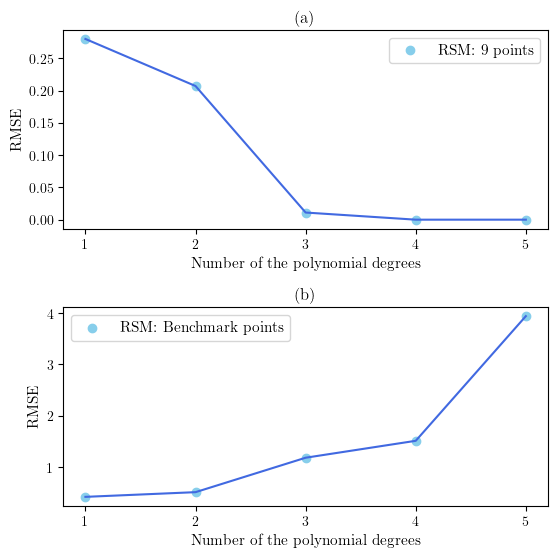

In [20]:
number_degrees = [1,2,3,4,5]
plt_MSE_train,plt_MSE_test,plt_r2_score_train,plt_r2_score_test = [],[],[],[]
X_test = np.column_stack(map(list,zip(*NLTHA_BM_pivot.index.values)))
y_test = np.log(lambda_BM_list)

for dgr in number_degrees:
    poly_model = PolynomialFeatures(degree=dgr)
    poly_x_train = poly_model.fit_transform(x_RSM)
    poly_x_test = poly_model.fit_transform(X_test)
    #[1, a, b, a^2, ab, b^2]
    poly_model.fit(poly_x_train, y_RSM)
    regression_model = LinearRegression()
    regression_model.fit(poly_x_train, y_RSM)
    y_train_pred = regression_model.predict(poly_x_train)
    y_test_pred = regression_model.predict(poly_x_test)
    r2_train = r2_score(y_train_pred[:,0], y_RSM[:,0])
    r2_test = r2_score(y_test_pred[:,0], y_test)
    plt_MSE_train.append(mean_squared_error(y_RSM[:,0], y_train_pred[:,0], squared=False))
    plt_MSE_test.append(mean_squared_error(y_test, y_test_pred[:,0], squared=False))
    plt_r2_score_train.append(r2)
    plt_r2_score_test.append(r2)

fig,ax = plt.subplots(2,1,figsize=(width*1/72.27,width*0.5*2/72.27))
ax[0].scatter(number_degrees,plt_MSE_train, color="skyblue",label='RSM: 9 points')
ax[0].plot(number_degrees,plt_MSE_train, color="royalblue")
ax[0].xaxis.get_major_locator().set_params(integer=True)
ax[0].set_xlabel('Number of the polynomial degrees')
ax[0].set_ylabel('RMSE')
ax[0].legend()
ax[0].set_title('(a)')


#ax.scatter(number_degrees,plt_r2_score_train, color="green")
#ax.plot(number_degrees,plt_r2_score_train, color="red")
ax[1].scatter(number_degrees,plt_MSE_test, color="skyblue",label='RSM: Benchmark points')
ax[1].plot(number_degrees,plt_MSE_test, color="royalblue")
ax[1].xaxis.get_major_locator().set_params(integer=True)
ax[1].set_xlabel('Number of the polynomial degrees')
ax[1].set_ylabel('RMSE')
ax[1].set_title('(b)')
ax[1].legend()

plt.savefig('resRMSE_vs_NDOF.pdf', backend='pdf', dpi=600)

fig.show()

*   Median fragility model estimated from the median probability of failure at each intensity measure level.
*  Log-mean estimations for each limit state combination in the dataset.

,0,5,10,15,20,25,30,35,40
0,0.0,2.202328e+00,11.727738,11.998703,11.999994,12.000000,12.000000,12.000000,12.000000
1,0.0,5.362789e-03,0.504417,2.560168,5.364643,7.777152,9.456265,10.509412,11.136448
2,0.0,1.198722e+01,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
3,0.0,1.369595e-01,5.966589,10.879997,11.857951,11.983421,11.998015,11.999746,11.999965
4,0.0,1.047204e+00,10.288932,11.922964,11.997159,11.999886,11.999995,12.000000,12.000000
...,...,...,...,...,...,...,...,...,...
995,0.0,3.493969e-02,11.963528,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
996,0.0,2.668531e-03,0.338191,1.992155,4.564909,7.006890,8.842549,10.068201,10.837135
997,0.0,4.014044e+00,11.719294,11.995977,11.999936,11.999999,12.000000,12.000000,12.000000
998,0.0,3.178679e-08,0.007379,0.526202,3.187077,7.010309,9.784919,11.162735,11.713414


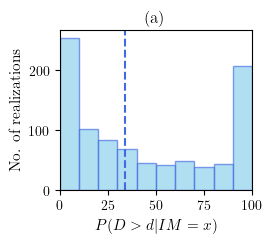

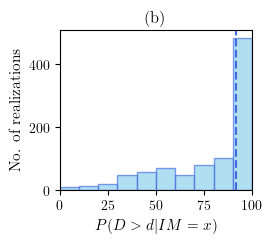

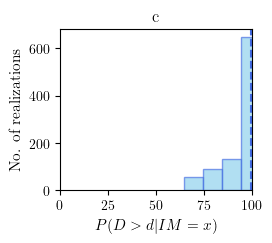

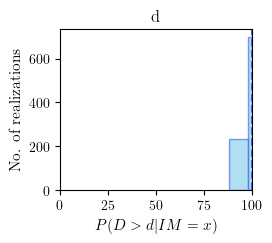

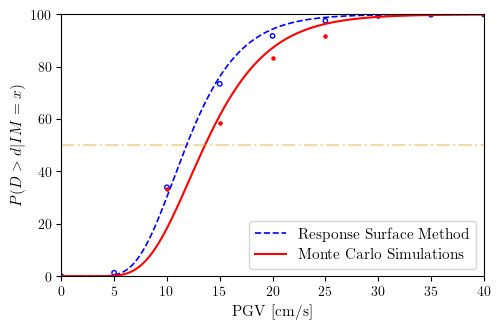

In [21]:
# note: np.median() --> produces error when nan exist, while np.nanmedian() and dataset.median() ignores the nan values.

for y,sel_IM,title in zip([0,1,2,3],["10","20","30","40"],['(a)','(b)','c','d']):
  fig, ax = plt.subplots(figsize=(width*0.5/72.27,width*0.45/72.27))

  ax.hist(fragility_table_RSM_1000_deg2[sel_IM]*100/12,color='skyblue', edgecolor='royalblue', alpha=0.65,bins=np.arange((fragility_table_RSM_1000_deg2[sel_IM]*100/12).min(), (fragility_table_RSM_1000_deg2[sel_IM]*100/12).max() + 10, 10))
  ax.set_xlim(0,100)
  ax.xaxis.set_major_formatter(pticks)
  ax.set_ylim(0)
  ax.set_xlabel(r"$P(D>d|IM=x)$")
  #ax.set_xticks([np.linspace(0,1.1,0.1)])
  ax.set_ylabel('No. of realizations')   ## Mean or median?????????? ANS: Median
  ax.set_title(title) ### Title is not ready
  ax.axvline(fragility_table_RSM_1000_deg2[sel_IM].median()*100/12, color='royalblue', linestyle='--', linewidth=1.5)
  plt.savefig('hist_RSM_'+str(sel_IM)+'.pdf', backend='pdf', dpi=600, bbox_inches="tight", transparent=True)


        # 1000 points of x,    interpolation for the curve,                                                              clearing non-zeroes

fig, ax = plt.subplots(figsize=(width*0.9/72.27,width*0.6/72.27))

ax.plot(np.linspace(0,40,1000),RSM_1000_lgnrml_deg2*100,linestyle='--',color='blue',label='Response Surface Method', linewidth=1.2)

ax.scatter(np.arange(0,45,5),fragility_table_RSM_1000_deg2.median()*100/12,s=10, facecolors='none', edgecolors='blue',linewidth=1)

ax.plot(np.linspace(0,40,100),NLTHA_BM_frag*100,linestyle='-',color='red',label='Monte Carlo Simulations',linewidth=1.5)
ax.scatter(np.arange(0,45,5),NLTHA_BM_pivot.median()*100,s=5,color='red')
ax.axhline(50,color='goldenrod',alpha=0.4,linestyle='-.')

ax.set_xlim(0,40)
ax.set_ylim(0,100)
ax.yaxis.set_major_formatter(pticks)
ax.set_xlabel('PGV [cm/s]')
ax.set_ylabel(r"$P(D>d|IM=x)$")
ax.legend()

fmt = '%.0f%%' # Format the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)

# do not forget to make the straight line between 0 and 5
plt.savefig('finalfrag_RSM.pdf', backend='pdf', dpi=600, bbox_inches="tight", transparent=True)

#print(np.linspace(0,40,1000)[np.where(RSM_1000_lgnrml_deg2 >= 0.5)[0][0]])

fragility_table_RSM_1000_deg2

# **3. Artifical neural networks**

The Second machine learning algorithm used in our study is Artificial Neural Networks (ANN), an advanced machine learning algorithm utilized in our study. ANNs approach is used to predict the parameters defining the fragility model. The dataset used for training the networks are grid sampling generated limit state combinations analyzed through nonlinear time history analysis. The dataset comprises 49 limit state combinations (7 different limit states paired with each other).

### 2.3.1 Preparing the training dataset

Analysis results are retrieved from the project repository, and the limit states are normalized to meta-variables.

In [22]:

NLTHA_ANN = pd.read_csv('https://github.com/mtareqsoliman/msthesis/blob/main/CaseStudy_1/sims_ANN_c1.csv?raw=true')

                          # ln(x)                                mean(ln(x))                                  stdev(ln(x))

ecu_ANN_alpha = sps.norm.cdf(np.log(-np.array(NLTHA_ANN[['ecu']])), loc=np.log(0.006),scale=np.sqrt(np.log(1+(0.35)**2)))
Vult_ANN_alpha = sps.norm.cdf(np.log(np.array(NLTHA_ANN[['Vult']])), loc=np.log(170),scale=np.sqrt(np.log(1+(0.20)**2)))

ecu_ANN_alpha, Vult_ANN_alpha = sps.norm.ppf(ecu_ANN_alpha,0,1) , sps.norm.ppf(Vult_ANN_alpha,0,1)

NLTHA_ANN['ecu_alpha'] = ecu_ANN_alpha
NLTHA_ANN['Vult_alpha'] = Vult_ANN_alpha

NLTHA_ANN.head(10)

,state,IM,record,ecu,Vult,Vbmax,ect,ecb,uindex,convergence,ecu_alpha,Vult_alpha,Unnamed: 12
0,1,40,RSN126_GAZLI_GAZ000,-0.003040,114.401482,150.040474,-0.093270,-0.113045,488,0,-2.000000,-2.000000,NaN
1,1,40,RSN126_GAZLI_GAZ000,-0.003813,114.401482,150.040474,-0.002846,-0.123333,488,FAILED,-1.333333,-2.000000,NaN
2,1,40,RSN126_GAZLI_GAZ000,-0.004783,114.401482,150.040474,-0.002272,-0.156837,488,0,-0.666667,-2.000000,NaN
3,1,40,RSN126_GAZLI_GAZ000,-0.006000,114.401482,150.040474,-0.003017,-0.143742,488,0,0.000000,-2.000000,NaN
4,1,40,RSN126_GAZLI_GAZ000,-0.007526,114.401482,150.040474,-0.003178,-0.145842,488,0,0.666667,-2.000000,NaN
5,1,40,RSN126_GAZLI_GAZ000,-0.009441,114.401482,153.321827,-0.002361,-0.129268,488,FAILED,1.333333,-2.000000,NaN
6,1,40,RSN126_GAZLI_GAZ000,-0.011842,114.401482,153.051862,-0.003152,-0.084686,488,FAILED,2.000000,-2.000000,NaN
7,1,40,RSN126_GAZLI_GAZ000,-0.003040,130.548156,150.040474,-0.093270,-0.113045,569,0,-2.000000,-1.333333,NaN
8,1,40,RSN126_GAZLI_GAZ000,-0.003813,130.548156,150.040474,-0.002846,-0.123333,569,FAILED,-1.333333,-1.333333,NaN
9,1,40,RSN126_GAZLI_GAZ000,-0.004783,130.548156,150.040474,-0.002272,-0.156837,569,0,-0.666667,-1.333333,NaN


The table below illustrates the number of failures at each IM level for each meta-variable in the grid dataset (out of 12 simulations per each IM level).

In [23]:
NLTHA_ANN_pivot = pd.pivot_table(NLTHA_ANN, values='state', index=['ecu_alpha','Vult_alpha'],columns=['IM'], aggfunc=np.sum)  #merging rows makes more problems so leave them as they are
NLTHA_ANN_pivot.insert(0,0,0)

'''
#############################
# These are for future plans
#############################

#NLTHA_ANN['flex_fail'] = np.greater(NLTHA_ANN['ecu'],np.minimum(NLTHA_ANN['ecb'],NLTHA_ANN['ecb']))
#NLTHA_ANN['shear_fail'] = np.greater(NLTHA_ANN['Vbmax'],NLTHA_ANN['Vult'])

NLTHA_ANN_strain_pivot = pd.pivot_table(NLTHA_ANN, values='flex_fail', index=['ecu_alpha','Vult_alpha'],columns=['IM'], aggfunc=np.sum)  #merging rows makes more problems so leave them as they are
NLTHA_ANN_strain_pivot.insert(0,0,0)


NLTHA_ANN_shear_pivot = pd.pivot_NLTHA_ANN_pivot = pd.pivot_table(NLTHA_ANN, values='state', index=['ecu_alpha','Vult_alpha'],columns=['IM'], aggfunc=np.sum)  #merging rows makes more problems so leave them as they are
NLTHA_ANN_shear_pivot.insert(0,0,0)

#NLTHA_ANN_strain_pivot.to_latex()
'''


NLTHA_ANN_pivot

IM                    0   5   10  15  20  25  30  35  40
ecu_alpha Vult_alpha                                    
-2.000000 -2.000000    0  11  12  12  12  12  12  12  12
          -1.333333    0   5  12  12  12  12  12  12  12
          -0.666667    0   2   8  12  12  12  12  12  12
           0.000000    0   0   5   8  11  12  12  12  12
           0.666667    0   0   5   8  11  12  12  12  12
           1.333333    0   0   5   8  11  12  12  12  12
           2.000000    0   0   5   8  11  12  12  12  12
-1.333333 -2.000000    0  11  12  12  12  12  12  12  12
          -1.333333    0   5  12  12  12  12  12  12  12
          -0.666667    0   2   8  12  12  12  12  12  12
           0.000000    0   0   5   7  11  11  12  12  12
           0.666667    0   0   5   7  11  11  12  12  12
           1.333333    0   0   5   7  11  11  12  12  12
           2.000000    0   0   5   7  11  11  12  12  12
-0.666667 -2.000000    0  11  12  12  12  12  12  12  12
          -1.333333    0   5  12  12  12  12  12  12  12
          -0.666667    0   2   8  12  12  12  12  12  12
           0.000000    0   0   4   7  10  11  12  12  12
           0.666667    0   0   4   7  10  11  12  12  12
           1.333333    0   0   4   7  10  11  12  12  12
           2.000000    0   0   4   7  10  11  12  12  12
 0.000000 -2.000000    0  11  12  12  12  12  12  12  12
          -1.333333    0   5  12  12  12  12  12  12  12
          -0.666667    0   2   8  12  12  12  12  12  12
           0.000000    0   0   2   7  10  10  11  12  12
           0.666667    0   0   2   7  10  10  11  12  12
           1.333333    0   0   2   7  10  10  11  12  12
           2.000000    0   0   2   7  10  10  11  12  12
 0.666667 -2.000000    0  11  12  12  12  12  12  12  12
          -1.333333    0   5  12  12  12  12  12  12  12
          -0.666667    0   2   8  12  12  12  12  12  12
           0.000000    0   0   1   4   9  10  11  12  12
           0.666667    0   0   1   4   9  10  11  12  12
           1.333333    0   0   1   4   9  10  11  12  12
           2.000000    0   0   1   4   9  10  11  12  12
 1.333333 -2.000000    0  11  12  12  12  12  12  12  12
          -1.333333    0   5  12  12  12  12  12  12  12
          -0.666667    0   2   8  12  12  12  12  12  12
           0.000000    0   0   1   4   8  10  11  10  11
           0.666667    0   0   1   4   8  10  11  10  11
           1.333333    0   0   1   4   8  10  11  10  11
           2.000000    0   0   1   4   8  10  11  10  11
 2.000000 -2.000000    0  11  12  12  12  12  12  12  12
          -1.333333    0   5  12  12  12  12  12  12  12
          -0.666667    0   2   8  12  12  12  12  12  12
           0.000000    0   0   0   3   8  10  10   9  10
           0.666667    0   0   0   3   8  10  10   9  10
           1.333333    0   0   0   3   8  10  10   9  10
           2.000000    0   0   0   3   8  10  10   9  10

### 2.3.2 Calculating fragility model parameters for each limit state combination

For each meta-variable combination, the probability of failures is curve-fitted with a log-normal CDF function. The parameters λ and ζ, defining the CDF function, are estimated using the least squares method. A graph displaying the values of the estimated parameters is presented below.

         eps         V  $lambda$  $zeta$   cost
0  -2.000000 -2.000000      5.00    0.20  -5.84
1  -2.000000 -1.333333      5.21    0.20  -1.48
2  -2.000000 -0.666667      7.63    0.38  -3.52
3  -2.000000  0.000000     11.70    0.36  -4.70
4  -2.000000  0.666667     11.70    0.36  -4.70
5  -2.000000  1.333333     11.70    0.36  -4.70
6  -2.000000  2.000000     11.70    0.36  -4.70
7  -1.333333 -2.000000      5.00    0.20  -5.84
8  -1.333333 -1.333333      5.21    0.20  -1.48
9  -1.333333 -0.666667      7.63    0.38  -3.52
10 -1.333333  0.000000     12.23    0.42  -6.18
11 -1.333333  0.666667     12.23    0.42  -6.18
12 -1.333333  1.333333     12.23    0.42  -6.18
13 -1.333333  2.000000     12.23    0.42  -6.18
14 -0.666667 -2.000000      5.00    0.20  -5.84
15 -0.666667 -1.333333      5.21    0.20  -1.48
16 -0.666667 -0.666667      7.63    0.38  -3.52
17 -0.666667  0.000000     13.02    0.41  -5.91
18 -0.666667  0.666667     13.02    0.41  -5.91
19 -0.666667  1.333333     13.02    0.41

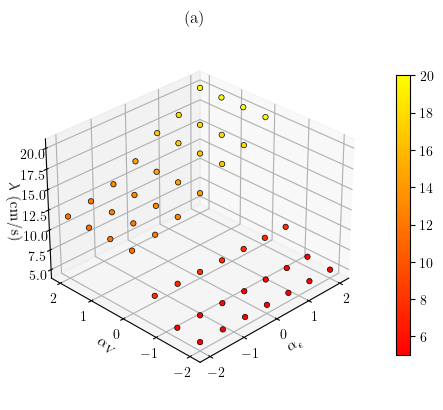

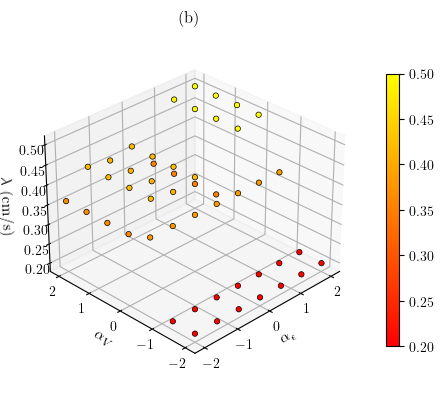

In [24]:
##pivot_numpy = np.concatenate((np.zeros(9)[:, np.newaxis], pivot_numpy), axis=1)
ecu_ANN_alpha, Vult_ANN_alpha = zip(*NLTHA_ANN_pivot.index.values)
ecu_ANN_alpha, Vult_ANN_alpha = np.asarray(ecu_ANN_alpha), np.asarray(Vult_ANN_alpha)

result_ANN_list,lambda_ANN_list,zeta_ANN_list = [],[],[]

IM = np.arange(0,45,5)
fragility_table_ANN = pd.DataFrame(columns = ['0','5','10','15','20','25','30','35','40'])
z_list = []


def frag(lambdazeta):
    estimated_fragility = sps.norm.cdf(np.log(factor_list),np.log(lambdazeta[0]),lambdazeta[1])
    log_likelihood = np.log(sps.binom.pmf(pcllps*nrcrds,nrcrds,estimated_fragility))
    fun = -np.sum(log_likelihood)

    return fun

for i,ecu_i in enumerate(ecu_ANN_alpha):
    factor_list = np.array([0,5,10,15,20,25,30,35,40])
    ncllps_NLTHA_ANN = NLTHA_ANN_pivot.iloc[i]
    nrcrds = 12
    pcllps = ncllps_NLTHA_ANN/nrcrds
    # starting guess
    lambdazeta_start = [20,0.32]
    # Bounds
    bnds = ((5, 50), (0.2, 1))


    result = spo.minimize(frag,lambdazeta_start,options={'disp': True},bounds=bnds)

    if result.success:
        miny = result.x
        lambda_mxlk = round(miny[0],2)
        zeta_mxlk = round(miny[1],2)
        lambda_ANN_list.append(lambda_mxlk)
        zeta_ANN_list.append(zeta_mxlk)

        z_mxlk = -round(result.fun,2)
        z_list.append(z_mxlk)
        fragility_table_ANN.loc[i] = sps.norm.cdf(np.log(IM),np.log(lambda_mxlk),zeta_mxlk)

lambda_ANN_list = np.array(lambda_ANN_list)
zeta_ANN_list = np.array(zeta_ANN_list)

print(pd.DataFrame({"eps":ecu_ANN_alpha,"V":Vult_ANN_alpha,"$lambda$":lambda_ANN_list,'$zeta$':zeta_ANN_list,'cost':z_list},index=None))

# Creating plot
fig, ax = plt.subplots(figsize=(width*0.8/72.27,width*0.8/72.27),subplot_kw={'projection': '3d'})
ax.autoscale(enable=True, axis='x', tight=True)
ax.set_zlabel(r"$\lambda$ (cm/s)",labelpad=-5)
ax.set_xlabel(r"$\alpha_\epsilon$",labelpad=-5)
ax.set_ylabel(r"$\alpha_{V}$",labelpad=-5)
ax.set_title("(a)")
ax.tick_params(axis='both', which='major', pad=-2)
ax.azim = 225
ax.set_box_aspect(aspect=None, zoom=0.9)

ANN_lambda_surf = ax.scatter(ecu_ANN_alpha, Vult_ANN_alpha, lambda_ANN_list,c=lambda_ANN_list,s=15,edgecolors='black', cmap='autumn',linewidth=0.5,alpha=1)
fig.colorbar(ANN_lambda_surf, ax=ax,fraction=0.035, pad=0.04)

fig.show()

# Creating plot
fig, ax = plt.subplots(figsize=(width*0.8/72.27,width*0.8/72.27),subplot_kw={'projection': '3d'})
ax.autoscale(enable=True, axis='x', tight=True)
ax.set_zlabel(r"$\lambda$ (cm/s)",labelpad=-2)
ax.set_xlabel(r"$\alpha_\epsilon$",labelpad=-5)
ax.set_ylabel(r"$\alpha_{V}$",labelpad=-5)
ax.set_title("(b)")
ax.tick_params(axis='both', which='major', pad=-2)
ax.azim = 225
ax.set_box_aspect(aspect=None, zoom=0.9)

ANN_zeta_surf = ax.scatter(ecu_ANN_alpha, Vult_ANN_alpha, zeta_ANN_list,c=zeta_ANN_list,s=15,edgecolors='black', cmap='autumn',linewidth=0.5,alpha=1)
fig.colorbar(ANN_zeta_surf, ax=ax,fraction=0.035, pad=0.04)

fig.show()

### 2.3.3 Training the ANN

Results from each grid meta-variable combination are employed to train the neural networks. The neural networks work to predict the defining parameters of the fragility model: λ and ζ.

0.040213849671621824


<ipython-input-25-1f5946a62609>:46: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cbar1.draw_all()
<ipython-input-25-1f5946a62609>:65: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cbar2.draw_all()


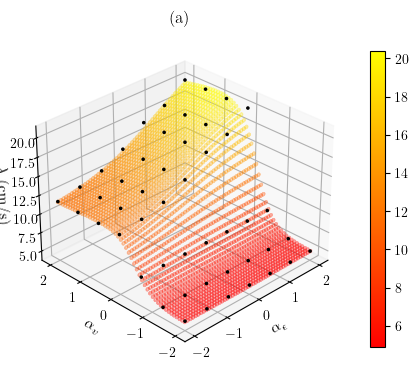

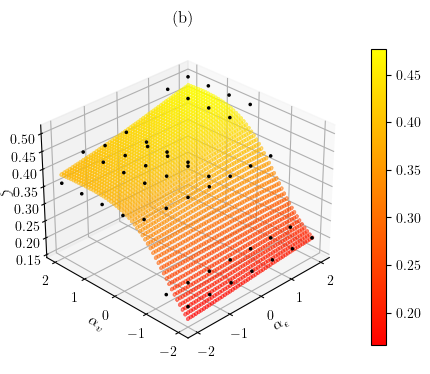

In [25]:

ecu_ANN_alpha, Vult_ANN_alpha = map(list,zip(*NLTHA_ANN_pivot.index.values))
x_ANN =np.column_stack((ecu_ANN_alpha,Vult_ANN_alpha))
y_ANN = np.column_stack((np.log(lambda_ANN_list),zeta_ANN_list))

nneurons = 5
nlyrs = 3

regr_ANN = MLPRegressor(hidden_layer_sizes=(5,3),solver='lbfgs', alpha=0.01,activation='logistic')
regr_ANN.fit(x_ANN, y_ANN[:,0])
regr_ANN_zeta = MLPRegressor(hidden_layer_sizes=(5,3),solver='lbfgs', alpha=0.01,activation='logistic')
regr_ANN_zeta.fit(x_ANN, y_ANN[:,1])

y_pred_ANN_lambda = regr_ANN.predict(x_ANN)
y_pred_ANN_zeta = regr_ANN_zeta.predict(x_ANN)
y_pred_ANN = np.column_stack((y_pred_ANN_lambda,y_pred_ANN_zeta))

MSE = mean_squared_error(y_ANN[:,0], y_pred_ANN[:,0], squared=False)


print(MSE)


x1_mesh_ANN,x2_mesh_ANN = np.linspace(-2, 2, 50), np.linspace(-2, 2, 50)
x1_mesh_ANN, x2_mesh_ANN = np.meshgrid(x1_mesh_ANN, x2_mesh_ANN)
X_mesh_ANN = np.array([x1_mesh_ANN.flatten(), x2_mesh_ANN.flatten()]).T
y_mesh_ANN_pred_lambda = regr_ANN.predict(X_mesh_ANN)
y_mesh_ANN_pred_zeta = regr_ANN_zeta.predict(X_mesh_ANN)
y_mesh_ANN_pred = np.column_stack((y_mesh_ANN_pred_lambda,y_mesh_ANN_pred_zeta))

fig, ax = plt.subplots(figsize=(width*0.8/72.27,width*0.8/72.27),subplot_kw={'projection': '3d'})
ax.autoscale(enable=True, axis='x', tight=True)
ax.set_zlabel(r"$\lambda$ (cm/s)",labelpad=-5)
ax.set_xlabel(r"$\alpha_\epsilon$",labelpad=-5)
ax.set_ylabel(r"$\alpha_v$",labelpad=-5)
ax.set_title("(a)")
ax.tick_params(axis='both', which='major', pad=-2)
ax.scatter(x_ANN[:,0], x_ANN[:,1], np.exp(y_ANN[:,0]),color='black',marker='.',alpha=1,s=10)
sc_1 = ax.scatter(x1_mesh_ANN, x2_mesh_ANN, np.exp(y_mesh_ANN_pred[:,0]), c=np.exp(y_mesh_ANN_pred[:,0]),marker="$\u25EF$", s=5, cmap='autumn',alpha=0.35)
ax.azim = 225
ax.set_box_aspect(aspect=None, zoom=0.95)


#ax.scatter(x1_mesh_ANN, x2_mesh_ANN, np.exp(y_mesh_ANN[:,0]), facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')
cbar1 = fig.colorbar(sc_1,shrink=0.7)
cbar1.set_alpha(1)
cbar1.draw_all()

plt.savefig('ANN_surf_lambda.pdf', backend='pdf', dpi=600, bbox_inches="tight")

fig, ax = plt.subplots(figsize=(width*0.8/72.27,width*0.8/72.27),subplot_kw={'projection': '3d'})

ax.set_zlabel(r"$\zeta$",labelpad=-5)
ax.set_xlabel(r"$\alpha_\epsilon$",labelpad=-5)
ax.set_ylabel(r"$\alpha_v$",labelpad=-5)
ax.set_title("(b)")
ax.tick_params(axis='both', which='major', pad=0)
ax.scatter(x_ANN[:,0], x_ANN[:,1], y_ANN[:,1],color='black',marker='.',alpha=1,s=10)
#ax.scatter(x1_mesh_ANN, x2_mesh_ANN, y_mesh_ANN[:,1], facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')
sc_2 = ax.scatter(x1_mesh_ANN, x2_mesh_ANN, y_mesh_ANN_pred[:,1], c=y_mesh_ANN_pred[:,1],marker="$\u25EF$", s=5, cmap='autumn',alpha=0.55)
ax.azim = 225
ax.set_box_aspect(aspect=None, zoom=0.95)

cbar2 = fig.colorbar(sc_2,shrink=0.7)
cbar2.set_alpha(1)
cbar2.draw_all()

plt.savefig('ANN_surf_zeta.pdf', backend='pdf', dpi=600, bbox_inches="tight")

result_table = pd.DataFrame({'y_act':y_ANN.tolist(),'y_pred':y_pred_ANN.tolist()}).to_excel('ssss.xlsx')

IM = np.arange(0,45,5)
fragility_table_ANN = pd.DataFrame(columns = ['0','5','10','15','20','25','30','35','40'])
z_list = []

for i in np.arange(len(y_ANN)):
  fragility_table_ANN.loc[i] = sps.norm.cdf(np.log(IM),y_ANN[i,0],y_ANN[i,1])

### 2.3.4 Developing median ANN model from ample random samples

A large set of limit state combinations is randomly generated, and the median fragility model of the ANN is developed.


In [26]:
alpha_ecu_1000 = np.random.normal(0, 1, 1000)
alpha_Vult_1000 = np.random.normal(0, 1, 1000)

x_1000_ANN = np.array([alpha_ecu_1000, alpha_Vult_1000]).T
y_1000_ANN_lambda = regr_ANN.predict(x_1000_ANN)
y_1000_ANN_zeta = regr_ANN_zeta.predict(x_1000_ANN)
y_1000_ANN = np.column_stack((y_1000_ANN_lambda,y_1000_ANN_zeta))

fragility_table_ANN_1000_mesh = pd.DataFrame(columns = ['0','5','10','15','20','25','30','35','40'])

for i in np.arange(len(y_1000_ANN)):
  fragility_table_ANN_1000_mesh.loc[i] = sps.norm.cdf(np.log(IM),y_1000_ANN[i,0],y_1000_ANN[i,1])

def frag(lambdazeta):
    estimated_fragility = sps.norm.cdf(np.log(factor_list),np.log(lambdazeta[0]),lambdazeta[1])
    log_likelihood = np.log(sps.binom.pmf(ncllps_ANN1000_mesh,nrcrds,estimated_fragility))
    fun = -np.sum(log_likelihood)

    return fun

factor_list = np.array([0,5,10,15,20,25,30,35,40])
nrcrds = 12
ncllps_ANN1000_mesh = np.round(fragility_table_ANN_1000_mesh.median()*12)
pcllps_ANN1000 = ncllps_ANN1000_mesh/12

# starting guess
lambdazeta_start = np.array([15,0.4])

# Bounds
bnds = ((5, 50), (0.2, 1))

result = spo.minimize(frag,lambdazeta_start,options={'disp': True},bounds=bnds)
ANN1000_mesh_lgnrml = []
if result.success:
    print("Success!", end = '\n')
    miny = result.x
    ANN1000_mesh_lambda = round(miny[0],2)
    ANN1000_mesh_zeta = round(miny[1],2)
    ANN1000_mesh_cost = -round(result.fun,2)

ANN1000_mesh_lz = [ANN1000_mesh_lambda,ANN1000_mesh_zeta,ANN1000_mesh_cost]
ANN1000_mesh_lgnrml = sps.norm.cdf(np.log(np.linspace(0,40,1000)),np.log(ANN1000_mesh_lz[0]),ANN1000_mesh_lz[1])
ANN1000_mesh_lz

Success!


[13.19, 0.38, -5.53]

### 2.3.5 Plotting

*   Residual errors from predictions of fragility model parameters at each limit state combination of the benchmark for the RSM-based model vs the ANN-based model.

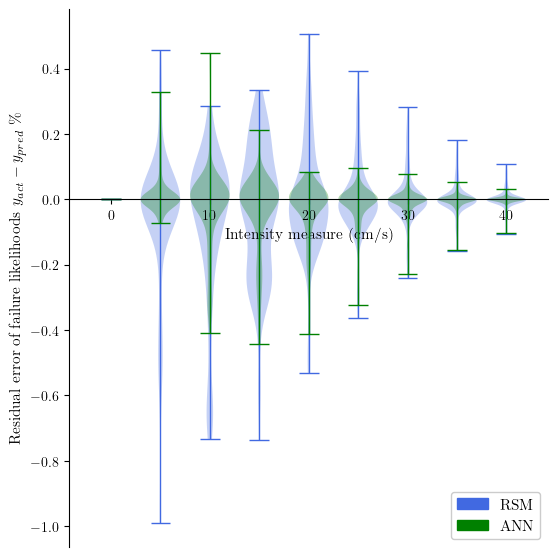

In [27]:
ecu_BM_alpha_frag, Vult_BM_alpha_frag = zip(*NLTHA_BM_pivot.index.values)

# "Fragility Table for ANN mesh method 100 Analyses"

x_BM = np.array([ecu_BM_alpha_frag, Vult_BM_alpha_frag]).T
y_BM_ANN_lambda = regr_ANN.predict(x_BM)
y_BM_ANN_zeta = regr_ANN_zeta.predict(x_BM)
y_BM_ANN = np.column_stack((y_BM_ANN_lambda,y_BM_ANN_zeta))

fragility_table_BM_ANN = pd.DataFrame(columns = ['0','5','10','15','20','25','30','35','40'])


for i in np.arange(len(y_BM_ANN)):
  fragility_table_BM_ANN.loc[i] = sps.norm.cdf(np.log(IM),y_BM_ANN[i,0],y_BM_ANN[i,1])


# "Fragility Table for RSM 100 Analyses"

fragility_table_BM_RSM_deg2 = pd.DataFrame(columns = ['0','5','10','15','20','25','30','35','40'])

x_BM_poly_RSM_deg2 = deg2_polymodel.fit_transform(x_BM)
#x_BM_poly_RSM_deg1 = deg1_polymodel.fit_transform(x_BM)

y_BM_RSM_deg2_lambda = deg2_RSM_regmodel.predict(x_BM_poly_RSM_deg2)[:,0]
y_BM_RSM_deg2_zeta = deg2_RSM_regmodel.predict(x_BM_poly_RSM_deg2)[:,1] # make it 1st degree model

y_BM_RSM_deg2 = np.column_stack((y_BM_RSM_deg2_lambda,y_BM_RSM_deg2_zeta))

IM = np.arange(0,45,5)
z_list = []

for i in np.arange(len(y_BM_RSM_deg2)):
  fragility_table_BM_RSM_deg2.loc[i] = sps.norm.cdf(np.log(IM),y_BM_RSM_deg2[i,0],y_BM_RSM_deg2[i,1])

fragility_table_BM_ANN.median()

y_ANN_residual = (-fragility_table_BM_ANN+fragility_table_BM)
y_RSM_deg2_residual = (-fragility_table_BM_RSM_deg2+fragility_table_BM)

fig, ax = plt.subplots(figsize=(width*1/72.27,width*1/72.27))

def add_label(violin, label):
    color = violin["bodies"][0].get_facecolor().flatten()
    labels.append((mpatches.Patch(color=color), label))

'''
for lbl,clr,rsdl,mrkr,lnwdth,eclr,alfa in zip(['ANN','RSM'],['none','royalblue'],[y_ANN_residual,y_RSM_deg2_residual],['<','>'],[0.5,0],['green','none'],[0.4,0.3]):
    for sel_IM in [0,5,10,15,20,25,30,35,40]:
        if sel_IM == 10:
          ax.scatter([sel_IM]*len(rsdl[str(sel_IM)]),rsdl[str(sel_IM)],color=clr,s=15,label=lbl,alpha=alfa,marker=mrkr,linewidth=lnwdth,edgecolors=eclr)
        else:
          ax.scatter([sel_IM]*len(rsdl[str(sel_IM)]),rsdl[str(sel_IM)],color=clr,s=15,alpha=alfa,marker=mrkr,linewidth=lnwdth,edgecolors=eclr)
'''

violin_1 = plt.violinplot(y_RSM_deg2_residual.dropna(),positions=[0,5,10,15,20,25,30,35,40],widths=4)

labels = []

for partname in ('cbars', 'cmins', 'cmaxes'):
    vp = violin_1[partname]
    vp.set_edgecolor('royalblue')
    vp.set_linewidth(1)

for patch in violin_1['bodies']:
    patch.set_facecolor('royalblue')



violin_2 = plt.violinplot(y_ANN_residual,positions=[0,5,10,15,20,25,30,35,40],widths=4)

for patch in violin_2['bodies']:
    patch.set_facecolor('green')
for partname in ('cbars', 'cmins', 'cmaxes'):
    vp2 = violin_2[partname]
    vp2.set_edgecolor('green')
    vp2.set_linewidth(1)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_ylabel(r"Residual error of failure likelihoods $y_{act}-y_{pred}$ \%")
ax.set_xlabel(r"Intensity measure (cm/s)")

#ax.set_yscale("logit")
ax.spines['bottom'].set_position('zero')


labels.append((mpatches.Patch(color='royalblue'), 'RSM'))
labels.append((mpatches.Patch(color='green'), 'ANN'))

leg = ax.legend(*zip(*labels), loc=4, fancybox=True, framealpha=1)

plt.savefig('residualviolin_ANN.pdf', backend='pdf', dpi=600, bbox_inches="tight", transparent=True)

*   Median fragility model estimated from the median probability of failure at each intensity measure level.

*   Log-mean estimations for each limit state combination in the dataset.


13.213213213213214


0     0.000000
5     0.009116
10    0.265007
15    0.650362
20    0.867001
25    0.952815
30    0.983369
35    0.994063
40    0.997837
dtype: float64

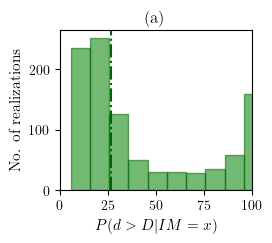

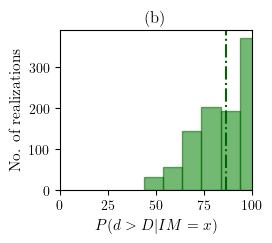

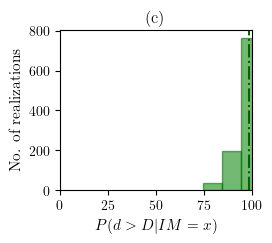

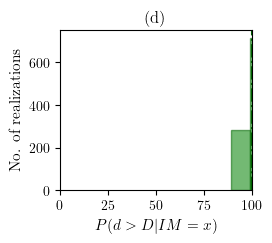

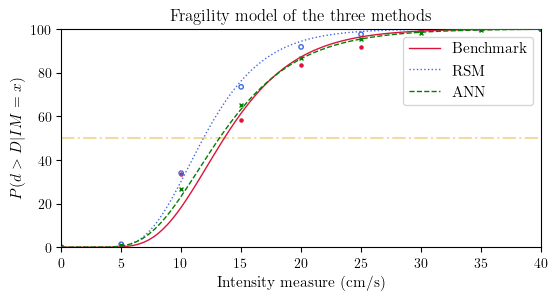

In [28]:
for y,sel_IM,title in zip([0,1,2,3],["10","20","30","40"],['(a)','(b)','(c)','(d)']):
  fig, ax = plt.subplots(figsize=(width*0.5/72.27,width*0.45/72.27))
  fig.tight_layout(pad=4.0)
  ax.hist(fragility_table_ANN_1000_mesh[sel_IM]*100,color='green', edgecolor='darkgreen', alpha=0.55,bins=np.arange(min(fragility_table_ANN_1000_mesh[sel_IM]*100), max(fragility_table_ANN_1000_mesh[sel_IM]*100) + 10, 10))
  ax.set_xlim(0,100)
  ax.xaxis.set_major_formatter(pticks)
  ax.set_ylim(0)
  ax.set_xlabel(r'$P(d>D|IM=x)$')
  ax.set_ylabel('No. of realizations')   ## Mean or median???????????????
  ax.set_title(title) ### Title is not ready
  ax.axvline(np.median(fragility_table_ANN_1000_mesh[sel_IM]*100,axis=0), color='darkgreen', linestyle='-.', linewidth=1.5)
  plt.savefig('hist_ANN_'+str(sel_IM)+'.pdf', backend='pdf', dpi=600, bbox_inches="tight", transparent=True)

fig, ax = plt.subplots(figsize=(width*1/72.27,width*0.55/72.27))

ax.plot(np.linspace(0,40,100),NLTHA_BM_frag*100,linestyle='-',color='crimson',label='Benchmark',linewidth=1,zorder=3)
ax.scatter(np.arange(0,45,5),NLTHA_BM_pivot.median()*100,s=5,color='crimson')

        # 1000 points of x,    interpolation for the curve,                                                              clearing non-zeroes
ax.plot(np.linspace(0,40,1000),RSM_1000_lgnrml_deg2*100,linestyle=':',color='royalblue',label='RSM',linewidth=1,zorder=2)

ax.scatter(np.arange(0,45,5),fragility_table_RSM_1000_deg2.median()*100/12,s=10, facecolors='none', edgecolors='royalblue',linewidth=1)
ax.scatter(np.arange(0,45,5),fragility_table_ANN_1000_mesh.median()*100,linewidth=1,s=8,marker='x',color='green')

ax.plot(np.linspace(0,40,1000),ANN1000_mesh_lgnrml*100,linestyle='--',color='green',label='ANN',linewidth=1,zorder=3)

fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)
ax.legend()
ax.set_xlim(0,40)
ax.set_ylim(0,100)
ax.set_title('Fragility model of the three methods')
ax.set_xlabel('Intensity measure (cm/s)')
ax.set_ylabel(r'$P(d>D|IM=x)$')
ax.axhline(50,color='goldenrod',alpha=0.4,linestyle='-.')
ax.legend()

# do not forget to make the straight line between 0 and 5
plt.savefig('finalfrag_RSMANN.pdf', backend='pdf', dpi=600, bbox_inches="tight", transparent=True)

#ANN1000_lgnrml

print(np.linspace(0,40,1000)[np.where(ANN1000_mesh_lgnrml >= 0.5)[0][0]])

fragility_table_ANN_1000_mesh.median()